## Import libraries and training data

In [1]:
import pandas as pd #data frames (for storing data)
import numpy as np #scientific computing
import itertools

#matplotlib for plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as mtick #for percentage ticks
import scikitplot as skplt 

#sklearn for modeling
from sklearn import tree
from sklearn.preprocessing import LabelEncoder #OneHotEncoding
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split #Data split function
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

from collections import Counter

import time
import statsmodels.api as sm

from sklearn.preprocessing import scale 
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

#Decision tree plot
import pydotplus
from IPython.display import Image 

Using TensorFlow backend.


# Training Data

In [2]:
data = pd.read_csv('LC_TrainingData2020.csv')
data.head().style

,loan_amnt,term,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,Unnamed: 20
0,14400,60 months,291.92,Senior Director,9,MORTGAGE,135000,Not Verified,Current,Home improvement,070xx,NJ,6.6,1,Oct.99,0,11,nan,15,0,nan
1,4500,36 months,151.06,Lead machine operator,6,RENT,32000,Not Verified,Current,Credit card refinancing,531xx,WI,29.93,0,Apr.11,1,nan,nan,7,0,nan
2,3600,36 months,118.53,IT Specialist 6,11,RENT,89712,Not Verified,Current,Credit card refinancing,984xx,WA,20.3,0,Aug.94,0,nan,nan,16,0,nan
3,7000,36 months,210.81,Nurse,2,RENT,85000,Not Verified,Current,Debt consolidation,112xx,NY,12.8,1,Feb.92,0,20,30,14,1,nan
4,39000,36 months,1370.94,Lead ultrasound technologist,19,MORTGAGE,78000,Source Verified,Current,Debt consolidation,453xx,OH,33.14,0,May.00,0,nan,nan,17,0,nan


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103514 entries, 0 to 103513
Data columns (total 21 columns):
loan_amnt                 103514 non-null int64
term                      103514 non-null object
installment               103514 non-null float64
emp_title                 96491 non-null object
emp_length                103514 non-null float64
home_ownership            103514 non-null object
annual_inc                103514 non-null float64
verification_status       103514 non-null object
loan_status               103514 non-null object
title                     103514 non-null object
zip_code                  103514 non-null object
addr_state                103514 non-null object
dti                       103514 non-null float64
delinq_2yrs               103514 non-null int64
earliest_cr_line          103514 non-null object
inq_last_6mths            103514 non-null int64
mths_since_last_delinq    55754 non-null float64
mths_since_last_record    21075 non-null float64
open_ac

In [4]:
data.shape

(103514, 21)

In [5]:
data.describe().round()

,loan_amnt,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,Unnamed: 20
count,103514.0,103514.0,103514.0,103514.0,103514.0,103514.0,103514.0,55754.0,21075.0,103514.0,103514.0,0.0
mean,14150.0,434.0,8.0,80759.0,19.0,0.0,1.0,34.0,68.0,12.0,0.0,NaN
std,9215.0,280.0,6.0,77231.0,12.0,1.0,1.0,22.0,25.0,6.0,1.0,NaN
min,1000.0,30.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN
25%,7000.0,230.0,2.0,48000.0,12.0,0.0,0.0,15.0,52.0,8.0,0.0,NaN
50%,12000.0,356.0,6.0,67600.0,18.0,0.0,0.0,30.0,71.0,11.0,0.0,NaN
75%,20000.0,582.0,13.0,96000.0,25.0,0.0,1.0,49.0,86.0,15.0,0.0,NaN
max,40000.0,1585.0,20.0,7000055.0,999.0,29.0,5.0,195.0,120.0,97.0,24.0,NaN


## Create target variable

In [6]:
# create target variable no default/default: 0/1

def default_category(row):
    if row['loan_status'] == 'Current' or row['loan_status'] == 'Fully Paid':
        return 0
    else:
        return 1

data = data.assign(default=data.apply(default_category, axis=1))
data.tail().style

,loan_amnt,term,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,Unnamed: 20,default
103509,16000,60 months,362.34,Manager,19,RENT,150000,Not Verified,Current,Medical expenses,284xx,NC,12.25,0,Aug.97,0,68,26,12,4,nan,0
103510,24000,60 months,515.74,Current Operations Officer,4,OWN,125000,Not Verified,Current,Credit card refinancing,967xx,HI,10.98,0,Feb.01,0,nan,42,15,2,nan,0
103511,24000,60 months,543.5,Unit Operator,7,MORTGAGE,95000,Source Verified,Current,Home improvement,356xx,AL,19.61,0,Dec.99,0,nan,nan,5,0,nan,0
103512,24000,60 months,515.74,Database Administrator,19,MORTGAGE,108000,Not Verified,Current,Debt consolidation,840xx,UT,34.94,0,Feb.91,1,60,69,24,1,nan,0
103513,24000,60 months,564.56,Program Manager,6,RENT,110000,Not Verified,Late (31-120 days),Debt consolidation,334xx,FL,18.3,0,Jul.99,0,67,72,10,1,nan,1


In [7]:
# dropping the loan status column which we don't need anymore and a redundant empty column that exists for some reason

data = data.drop(['loan_status', 'Unnamed: 20'], axis=1)
data.head().style

,loan_amnt,term,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,default
0,14400,60 months,291.92,Senior Director,9,MORTGAGE,135000,Not Verified,Home improvement,070xx,NJ,6.6,1,Oct.99,0,11,nan,15,0,0
1,4500,36 months,151.06,Lead machine operator,6,RENT,32000,Not Verified,Credit card refinancing,531xx,WI,29.93,0,Apr.11,1,nan,nan,7,0,0
2,3600,36 months,118.53,IT Specialist 6,11,RENT,89712,Not Verified,Credit card refinancing,984xx,WA,20.3,0,Aug.94,0,nan,nan,16,0,0
3,7000,36 months,210.81,Nurse,2,RENT,85000,Not Verified,Debt consolidation,112xx,NY,12.8,1,Feb.92,0,20,30,14,1,0
4,39000,36 months,1370.94,Lead ultrasound technologist,19,MORTGAGE,78000,Source Verified,Debt consolidation,453xx,OH,33.14,0,May.00,0,nan,nan,17,0,0


## Default and Home Ownership

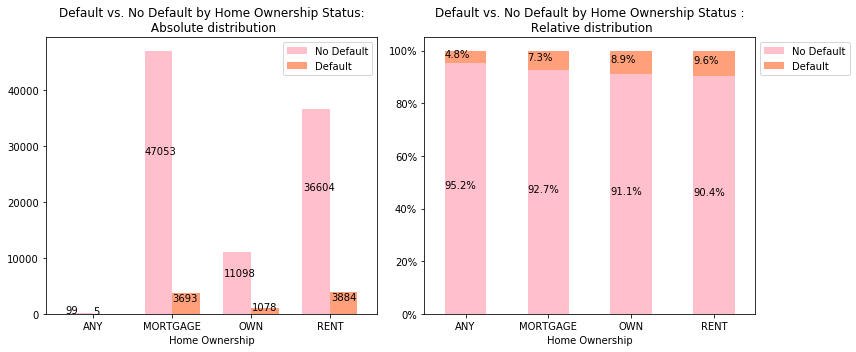

In [8]:
fig = plt.figure(figsize=(12, 5)) #specify figure size

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = data.groupby(['home_ownership', 'default'])['default'].count().unstack().plot.bar(rot=0, ax=plt.gca(), width=0.7, color=['pink','lightsalmon'])
plt.title('Default vs. No Default by Home Ownership Status:\n Absolute distribution') 
L = plt.legend()
L.get_texts()[0].set_text('No Default')
L.get_texts()[1].set_text('Default')
ax1.set_xlabel('Home Ownership')
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 0.605))

#Relative distribution
plt.subplot(1, 2, 2)
ax2 = data.groupby(['home_ownership','default'])['default'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=0, ax=plt.gca(), color=['pink','lightsalmon'])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
L = plt.legend(bbox_to_anchor=(1, 1))
L.get_texts()[0].set_text('No Default')
L.get_texts()[1].set_text('Default')
plt.title('Default vs. No Default by Home Ownership Status :\n Relative distribution') 
ax2.set_xlabel('Home Ownership')
#plot bar labels
for p, q in zip(ax2.patches[0:4], ax2.patches[4:8]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x(), p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x(), q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

In [9]:
print('Mortage proportion in default: ' + str(3693/8660))

Mortage proportion in default: 0.4264434180138568


## Default and Verification Status

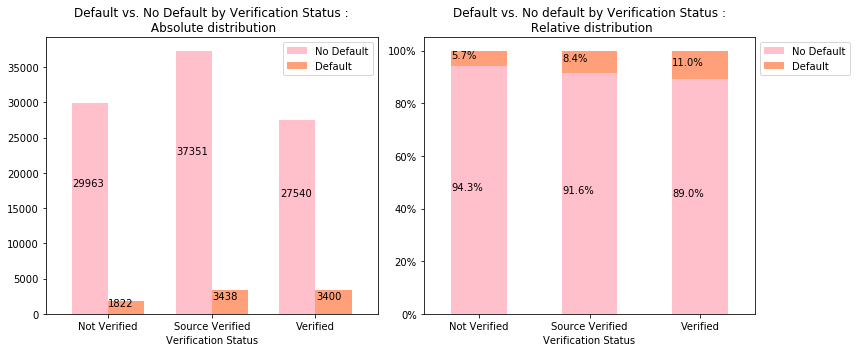

In [10]:
fig = plt.figure(figsize=(12, 5)) #specify figure size

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = data.groupby(['verification_status', 'default'])['default'].count().unstack().plot.bar(rot=0, ax=plt.gca(), width=0.7, color=['pink','lightsalmon'])
plt.title('Default vs. No Default by Verification Status :\n Absolute distribution') 
L = plt.legend()
L.get_texts()[0].set_text('No Default')
L.get_texts()[1].set_text('Default')
ax1.set_xlabel('Verification Status')
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 0.605))

#Relative distribution
plt.subplot(1, 2, 2)
ax2 = data.groupby(['verification_status','default'])['default'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=0, ax=plt.gca(), color=['pink','lightsalmon'])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Default vs. No default by Verification Status :\n Relative distribution') 
L = plt.legend(bbox_to_anchor=(1, 1))
L.get_texts()[0].set_text('No Default')
L.get_texts()[1].set_text('Default')
ax2.set_xlabel('Verification Status')
#plot bar labels
for p, q in zip(ax2.patches[0:3], ax2.patches[3:6]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x(), p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x(), q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

In [11]:
print('Not Verified proportion in default: ' + str(round(1822/8660,5)))

Not Verified proportion in default: 0.21039


## Default and Title

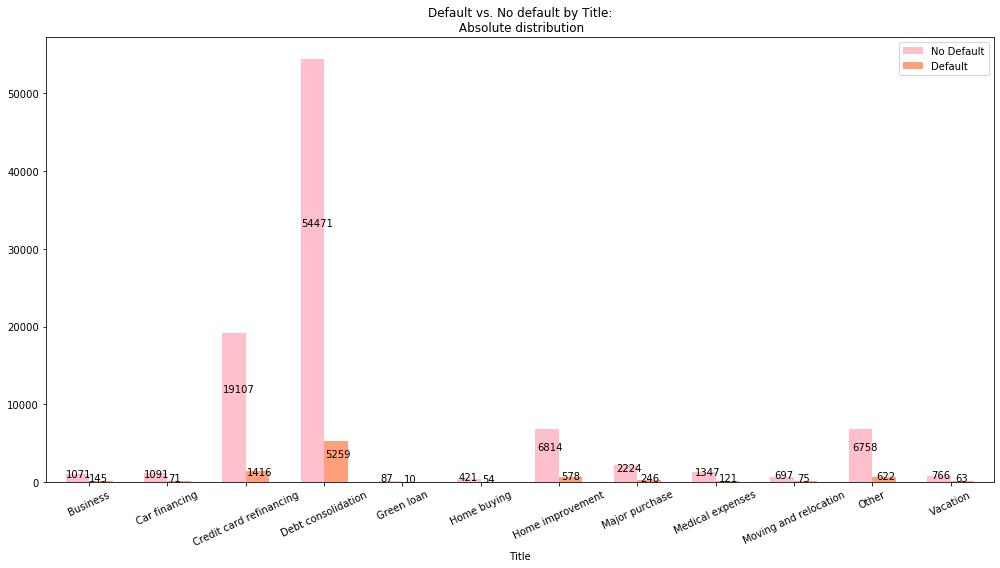

In [12]:
fig = plt.figure(figsize=(14, 8)) #specify figure size

#Absolute distribution
ax1 = data.groupby(['title', 'default'])['default'].count().unstack().plot.bar(rot=25, ax=plt.gca(), width=0.6, color=['pink','lightsalmon'])
plt.title('Default vs. No default by Title:\n Absolute distribution') 
L = plt.legend()
L.get_texts()[0].set_text('No Default')
L.get_texts()[1].set_text('Default')
ax1.set_xlabel('Title')
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 0.605))

plt.tight_layout()
plt.show()

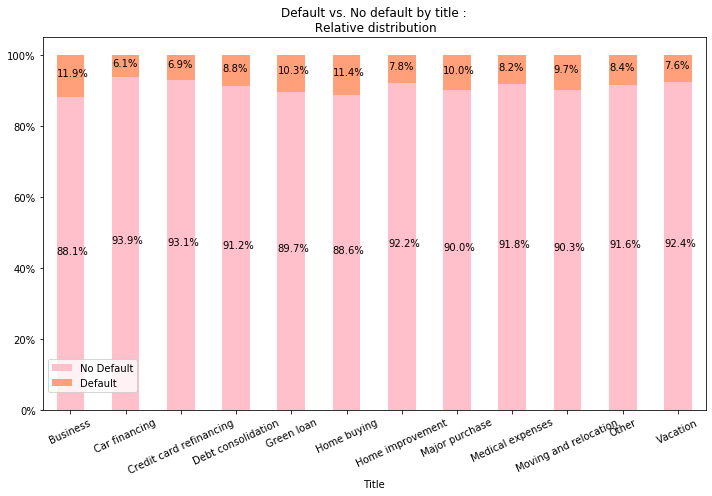

In [13]:
ax2 = data.groupby(['title','default'])['default'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=25, ax=plt.gca(), color=['pink','lightsalmon'], figsize=(10,7))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Default vs. No default by title :\n Relative distribution') 
L = plt.legend(bbox_to_anchor=(0.15, 0.15))
L.get_texts()[0].set_text('No Default')
L.get_texts()[1].set_text('Default')
ax2.set_xlabel('Title')
#plot bar labels
for p, q in zip(ax2.patches[0:12], ax2.patches[12:24]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x(), p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x(), q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

In [14]:
print('Credit card refinancing proportion in default: ' + str(round(1416/8660, 5)))

Credit card refinancing proportion in default: 0.16351


## Default and Addr_state (no grouping)

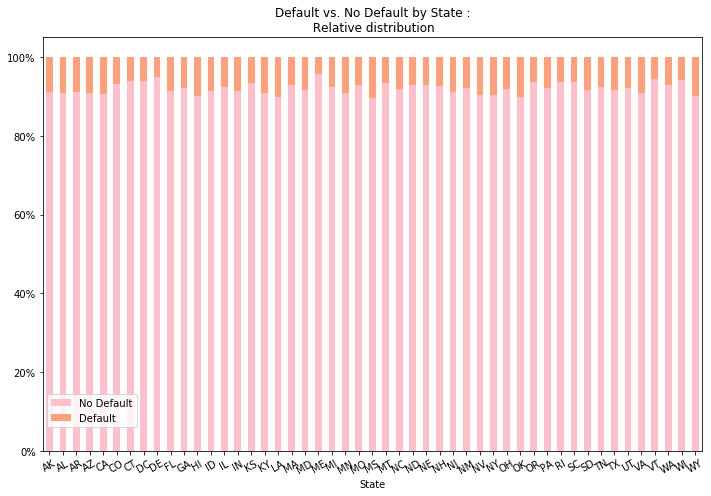

In [15]:
ax2 = data.groupby(['addr_state','default'])['default'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=30, ax=plt.gca(), color=['pink','lightsalmon'], figsize=(10,7))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Default vs. No Default by State :\n Relative distribution') 
L = plt.legend(bbox_to_anchor=(0.15, 0.15))
L.get_texts()[0].set_text('No Default')
L.get_texts()[1].set_text('Default')
ax2.set_xlabel('State')
#plot bar labels
#for p, q in zip(ax2.patches[0:49], ax2.patches[49:98]):
#    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x(), p.get_height()/2))
#    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x(), q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

In [16]:
loan_by_state = pd.DataFrame(data.groupby("addr_state")["loan_amnt"].sum())
loan_by_state = loan_by_state.sort_values(by=['loan_amnt'], ascending=True) 
loan_by_state = loan_by_state.reset_index()

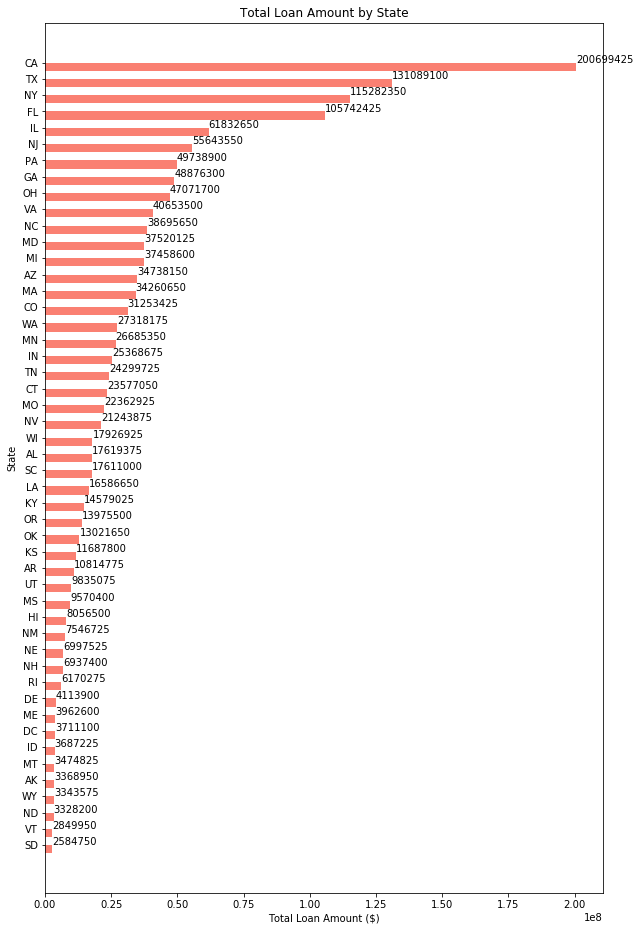

In [17]:
x = np.array(loan_by_state['addr_state'])
y = np.array(loan_by_state['loan_amnt'])

fig, ax = plt.subplots(figsize=(10, 16))    
width = 0.5 # the width of the bars 
ind = np.arange(len(x))  # the x locations for the groups
ax.barh(ind, y, width, color="salmon")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title('Total Loan Amount by State')
plt.ylabel('State')
plt.xlabel('Total Loan Amount ($)')   

for i, v in enumerate(y):
    ax.text(v + 3, i + .25, str(v))

plt.show()

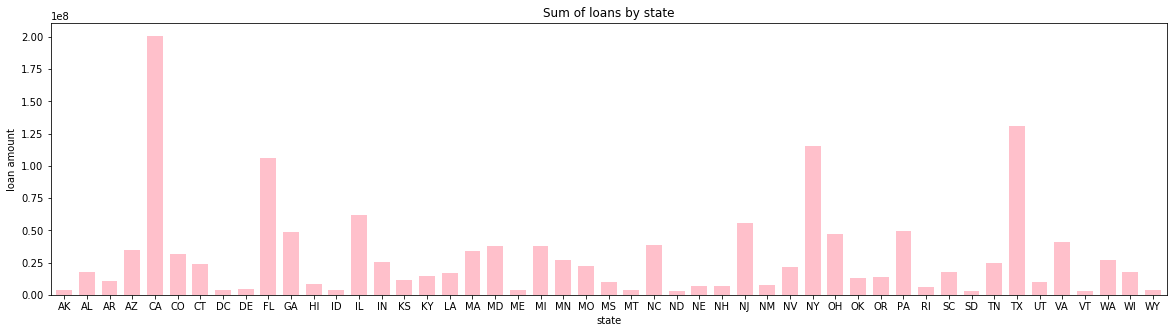

In [18]:
fig = plt.figure(figsize=(20, 5)) #specify figure size

ax1=data.groupby(['addr_state'])['loan_amnt'].sum().plot.bar(rot=0, color='pink', ax=plt.gca(), width=0.7)
plt.title('Sum of loans by state') 
#plot bar labels
#for p in ax1.patches:
   # ax1.annotate(str(p.get_height()), (p.get_x() + 0.1, p.get_height()/2))
plt.xlabel('state')
plt.ylabel('loan amount')
    
plt.show()

## Default and Loan Amount

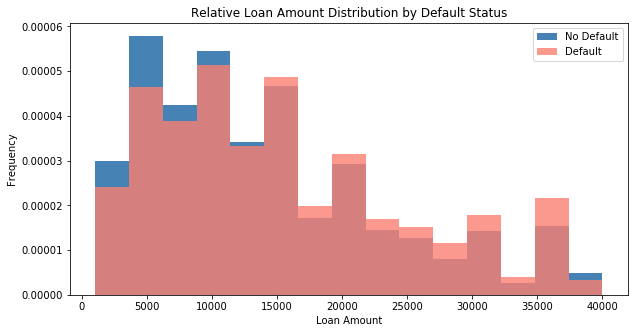

In [19]:
ax = data['loan_amnt'].loc[data['default'] == 0].plot.hist(bins=15, density = True, label='No Default', figsize = (10,5),color='steelblue')
ax = data['loan_amnt'].loc[data['default'] == 1].plot.hist(bins=15, density = True, alpha=0.8, label='Default', figsize = (10,5),color='salmon')
ax.set_xlabel('Loan Amount')
ax.set_title('Relative Loan Amount Distribution by Default Status')
ax.legend()

## Default and Annual Income

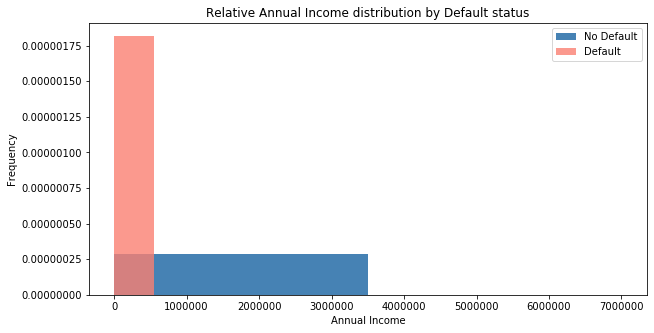

In [20]:
ax = data['annual_inc'].loc[data['default'] == 0].plot.hist(bins=2, density = True, label='No Default', figsize = (10,5),color='steelblue')
ax = data['annual_inc'].loc[data['default'] == 1].plot.hist(bins=2, density = True, alpha=0.8, label='Default', figsize = (10,5),color='salmon')
ax.set_xlabel('Annual Income')
ax.set_title('Relative Annual Income distribution by Default status')
ax.legend();

## Default and Employment Length

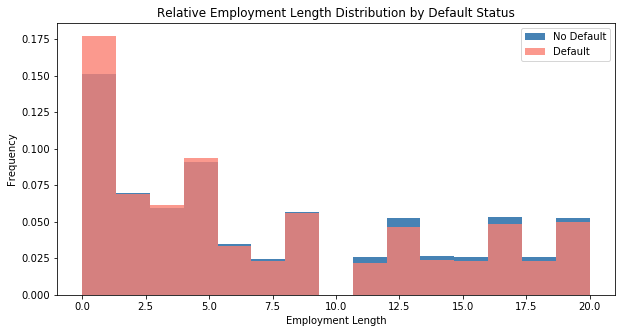

In [21]:
ax = data['emp_length'].loc[data['default'] == 0].plot.hist(bins=15, density = True, label='No Default', figsize = (10,5),color='steelblue')
ax = data['emp_length'].loc[data['default'] == 1].plot.hist(bins=15, density = True, alpha=0.8, label='Default', figsize = (10,5),color='salmon')
ax.set_xlabel('Employment Length')
ax.set_title('Relative Employment Length Distribution by Default Status')
ax.legend();

## Default and Installment

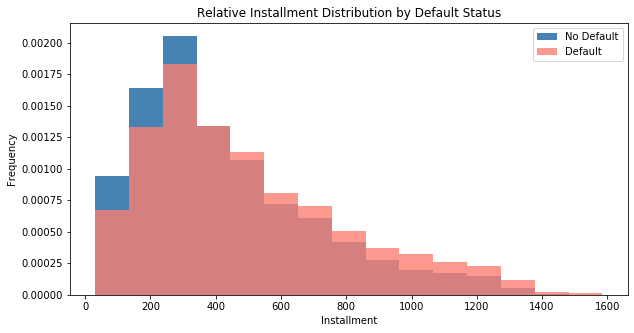

In [22]:
ax = data['installment'].loc[data['default'] == 0].plot.hist(bins=15, density = True, label='No Default', figsize = (10,5),color='steelblue')
ax = data['installment'].loc[data['default'] == 1].plot.hist(bins=15, density = True, alpha=0.8, label='Default', figsize = (10,5),color='salmon')
ax.set_xlabel('Installment')
ax.set_title('Relative Installment Distribution by Default Status')
ax.legend();

## Default and Open Account

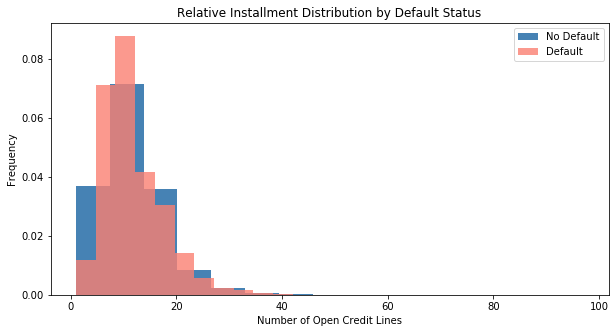

In [23]:
ax = data['open_acc'].loc[data['default'] == 0].plot.hist(bins=15, density = True, label='No Default', figsize = (10,5),color='steelblue')
ax = data['open_acc'].loc[data['default'] == 1].plot.hist(bins=15, density = True, alpha=0.8, label='Default', figsize = (10,5),color='salmon')
ax.set_xlabel('Number of Open Credit Lines')
ax.set_title('Relative Installment Distribution by Default Status')
ax.legend();

## Default and dit (smaller than 80 -> 103,426 out of 103,514 rows)

In [24]:
data2=data[data.dti <= 80]
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103426 entries, 0 to 103513
Data columns (total 20 columns):
loan_amnt                 103426 non-null int64
term                      103426 non-null object
installment               103426 non-null float64
emp_title                 96445 non-null object
emp_length                103426 non-null float64
home_ownership            103426 non-null object
annual_inc                103426 non-null float64
verification_status       103426 non-null object
title                     103426 non-null object
zip_code                  103426 non-null object
addr_state                103426 non-null object
dti                       103426 non-null float64
delinq_2yrs               103426 non-null int64
earliest_cr_line          103426 non-null object
inq_last_6mths            103426 non-null int64
mths_since_last_delinq    55712 non-null float64
mths_since_last_record    21058 non-null float64
open_acc                  103426 non-null int64
pub_rec 

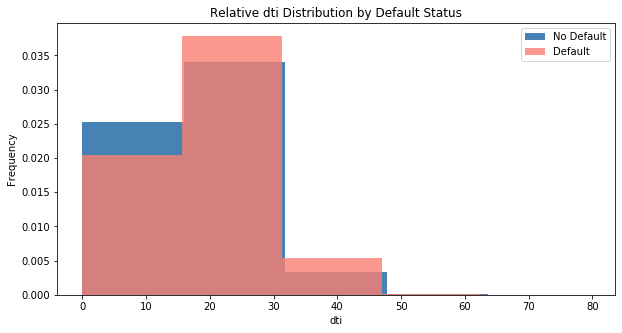

In [25]:
ax = data2['dti'].loc[data2['default'] == 0].plot.hist(bins=5, density = True, label='No Default', figsize = (10,5),color='steelblue')
ax = data2['dti'].loc[data2['default'] == 1].plot.hist(bins=5, density = True, alpha=0.8, label='Default', figsize = (10,5),color='salmon')
ax.set_xlabel('dti')
ax.set_title('Relative dti Distribution by Default Status')
ax.legend();

## Default and Term

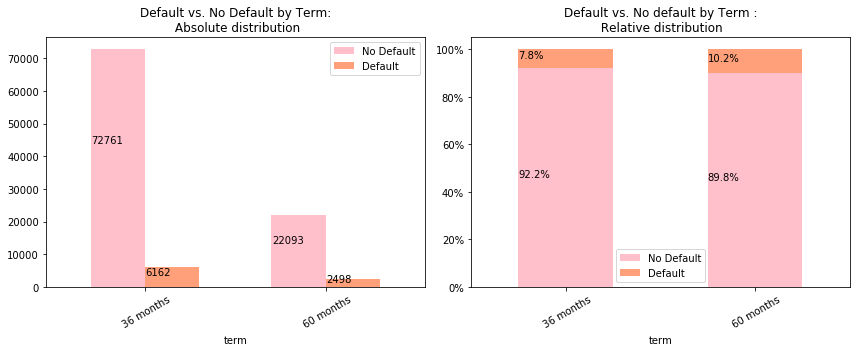

In [26]:
fig = plt.figure(figsize=(12, 5)) #specify figure size

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = data.groupby(['term', 'default'])['default'].count().unstack().plot.bar(rot=30, ax=plt.gca(), width=0.6, color=['pink','lightsalmon'])
plt.title('Default vs. No Default by Term:\n Absolute distribution') 
L = plt.legend()
L.get_texts()[0].set_text('No Default')
L.get_texts()[1].set_text('Default')
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 0.605))

#Relative distribution
plt.subplot(1, 2, 2)
ax2 = data.groupby(['term','default'])['default'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=30, ax=plt.gca(), color=['pink','lightsalmon'])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
L = plt.legend()
L.get_texts()[0].set_text('No Default')
L.get_texts()[1].set_text('Default')
plt.title('Default vs. No default by Term :\n Relative distribution') 
#plot bar labels
for p, q in zip(ax2.patches[0:2], ax2.patches[2:4]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x(), p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x(), q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

## Loan amount and Annual Income

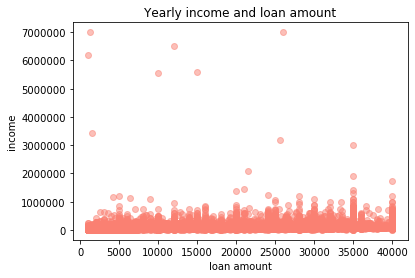

In [27]:
x=data['loan_amnt']
y=data['annual_inc']

plt.scatter(x, y, color='salmon', alpha=0.5)
plt.title('Yearly income and loan amount')
plt.xlabel('loan amount')
plt.ylabel('income')
plt.show()

## Delete months in variable 'term' and turn it into numerical values

In [28]:
new= data["term"].str.split(" ", n = -1, expand = True)
data["term_new"]=new[1]  
data["useless"]= new[2] 
data = data.drop(['useless'], axis=1)
data['term_new']=data['term_new'].astype(int)
data=data.drop(['term'], axis=1)
data.head().style

,loan_amnt,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,default,term_new
0,14400,291.92,Senior Director,9,MORTGAGE,135000,Not Verified,Home improvement,070xx,NJ,6.6,1,Oct.99,0,11,nan,15,0,0,60
1,4500,151.06,Lead machine operator,6,RENT,32000,Not Verified,Credit card refinancing,531xx,WI,29.93,0,Apr.11,1,nan,nan,7,0,0,36
2,3600,118.53,IT Specialist 6,11,RENT,89712,Not Verified,Credit card refinancing,984xx,WA,20.3,0,Aug.94,0,nan,nan,16,0,0,36
3,7000,210.81,Nurse,2,RENT,85000,Not Verified,Debt consolidation,112xx,NY,12.8,1,Feb.92,0,20,30,14,1,0,36
4,39000,1370.94,Lead ultrasound technologist,19,MORTGAGE,78000,Source Verified,Debt consolidation,453xx,OH,33.14,0,May.00,0,nan,nan,17,0,0,36


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103514 entries, 0 to 103513
Data columns (total 20 columns):
loan_amnt                 103514 non-null int64
installment               103514 non-null float64
emp_title                 96491 non-null object
emp_length                103514 non-null float64
home_ownership            103514 non-null object
annual_inc                103514 non-null float64
verification_status       103514 non-null object
title                     103514 non-null object
zip_code                  103514 non-null object
addr_state                103514 non-null object
dti                       103514 non-null float64
delinq_2yrs               103514 non-null int64
earliest_cr_line          103514 non-null object
inq_last_6mths            103514 non-null int64
mths_since_last_delinq    55754 non-null float64
mths_since_last_record    21075 non-null float64
open_acc                  103514 non-null int64
pub_rec                   103514 non-null int64
default  

## Convert earliest_cr_line to age of earliest cr line (in months):

In [30]:
data[['earliest_cr_Month','earliest_cr_Year']] = data.earliest_cr_line.str.split(".",expand=True,)
data.head().style

,loan_amnt,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,default,term_new,earliest_cr_Month,earliest_cr_Year
0,14400,291.92,Senior Director,9,MORTGAGE,135000,Not Verified,Home improvement,070xx,NJ,6.6,1,Oct.99,0,11,nan,15,0,0,60,Oct,99
1,4500,151.06,Lead machine operator,6,RENT,32000,Not Verified,Credit card refinancing,531xx,WI,29.93,0,Apr.11,1,nan,nan,7,0,0,36,Apr,11
2,3600,118.53,IT Specialist 6,11,RENT,89712,Not Verified,Credit card refinancing,984xx,WA,20.3,0,Aug.94,0,nan,nan,16,0,0,36,Aug,94
3,7000,210.81,Nurse,2,RENT,85000,Not Verified,Debt consolidation,112xx,NY,12.8,1,Feb.92,0,20,30,14,1,0,36,Feb,92
4,39000,1370.94,Lead ultrasound technologist,19,MORTGAGE,78000,Source Verified,Debt consolidation,453xx,OH,33.14,0,May.00,0,nan,nan,17,0,0,36,May,00


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103514 entries, 0 to 103513
Data columns (total 22 columns):
loan_amnt                 103514 non-null int64
installment               103514 non-null float64
emp_title                 96491 non-null object
emp_length                103514 non-null float64
home_ownership            103514 non-null object
annual_inc                103514 non-null float64
verification_status       103514 non-null object
title                     103514 non-null object
zip_code                  103514 non-null object
addr_state                103514 non-null object
dti                       103514 non-null float64
delinq_2yrs               103514 non-null int64
earliest_cr_line          103514 non-null object
inq_last_6mths            103514 non-null int64
mths_since_last_delinq    55754 non-null float64
mths_since_last_record    21075 non-null float64
open_acc                  103514 non-null int64
pub_rec                   103514 non-null int64
default  

In [32]:
def new_column_earliest_cr_Day(row):
    return 1

data = data.assign(earliest_cr_Day=data.apply(new_column_earliest_cr_Day, axis=1))
data.head(50).style

,loan_amnt,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,default,term_new,earliest_cr_Month,earliest_cr_Year,earliest_cr_Day
0,14400,291.92,Senior Director,9,MORTGAGE,135000,Not Verified,Home improvement,070xx,NJ,6.6,1,Oct.99,0,11,nan,15,0,0,60,Oct,99,1
1,4500,151.06,Lead machine operator,6,RENT,32000,Not Verified,Credit card refinancing,531xx,WI,29.93,0,Apr.11,1,nan,nan,7,0,0,36,Apr,11,1
2,3600,118.53,IT Specialist 6,11,RENT,89712,Not Verified,Credit card refinancing,984xx,WA,20.3,0,Aug.94,0,nan,nan,16,0,0,36,Aug,94,1
3,7000,210.81,Nurse,2,RENT,85000,Not Verified,Debt consolidation,112xx,NY,12.8,1,Feb.92,0,20,30,14,1,0,36,Feb,92,1
4,39000,1370.94,Lead ultrasound technologist,19,MORTGAGE,78000,Source Verified,Debt consolidation,453xx,OH,33.14,0,May.00,0,nan,nan,17,0,0,36,May,00,1
5,20000,712.96,teacher,11,MORTGAGE,63000,Not Verified,Debt consolidation,011xx,MA,29.03,1,marras.90,2,23,71,15,1,0,36,marras,90,1
6,8000,250.66,Techniti,20,MORTGAGE,57000,Source Verified,Credit card refinancing,666xx,KS,28.45,3,Oct.96,0,7,nan,7,0,0,36,Oct,96,1
7,9300,292.46,Banquet server,9,MORTGAGE,62000,Source Verified,Debt consolidation,481xx,MI,16.12,0,Jun.03,1,71,99,14,1,0,36,Jun,03,1
8,18000,563.98,Equipment Management,2,MORTGAGE,60000,Not Verified,Debt consolidation,329xx,FL,30.76,0,Oct.00,0,nan,nan,13,0,0,36,Oct,00,1
9,5000,162.49,driver,11,RENT,75000,Not Verified,Other,891xx,NV,11.01,0,Oct.90,1,nan,74,4,1,0,36,Oct,90,1


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103514 entries, 0 to 103513
Data columns (total 23 columns):
loan_amnt                 103514 non-null int64
installment               103514 non-null float64
emp_title                 96491 non-null object
emp_length                103514 non-null float64
home_ownership            103514 non-null object
annual_inc                103514 non-null float64
verification_status       103514 non-null object
title                     103514 non-null object
zip_code                  103514 non-null object
addr_state                103514 non-null object
dti                       103514 non-null float64
delinq_2yrs               103514 non-null int64
earliest_cr_line          103514 non-null object
inq_last_6mths            103514 non-null int64
mths_since_last_delinq    55754 non-null float64
mths_since_last_record    21075 non-null float64
open_acc                  103514 non-null int64
pub_rec                   103514 non-null int64
default  

In [34]:
## fix for formatting error that appears in finnish language version when csv has been opened in excel etc....

def marras_to_Mar(row):
    if row['earliest_cr_Month'] == 'marras':
        return 'Mar'
    else:
        return row['earliest_cr_Month']

data = data.assign(earliest_cr_Month=data.apply(marras_to_Mar, axis=1))
data.head(50).style

,loan_amnt,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,default,term_new,earliest_cr_Month,earliest_cr_Year,earliest_cr_Day
0,14400,291.92,Senior Director,9,MORTGAGE,135000,Not Verified,Home improvement,070xx,NJ,6.6,1,Oct.99,0,11,nan,15,0,0,60,Oct,99,1
1,4500,151.06,Lead machine operator,6,RENT,32000,Not Verified,Credit card refinancing,531xx,WI,29.93,0,Apr.11,1,nan,nan,7,0,0,36,Apr,11,1
2,3600,118.53,IT Specialist 6,11,RENT,89712,Not Verified,Credit card refinancing,984xx,WA,20.3,0,Aug.94,0,nan,nan,16,0,0,36,Aug,94,1
3,7000,210.81,Nurse,2,RENT,85000,Not Verified,Debt consolidation,112xx,NY,12.8,1,Feb.92,0,20,30,14,1,0,36,Feb,92,1
4,39000,1370.94,Lead ultrasound technologist,19,MORTGAGE,78000,Source Verified,Debt consolidation,453xx,OH,33.14,0,May.00,0,nan,nan,17,0,0,36,May,00,1
5,20000,712.96,teacher,11,MORTGAGE,63000,Not Verified,Debt consolidation,011xx,MA,29.03,1,marras.90,2,23,71,15,1,0,36,Mar,90,1
6,8000,250.66,Techniti,20,MORTGAGE,57000,Source Verified,Credit card refinancing,666xx,KS,28.45,3,Oct.96,0,7,nan,7,0,0,36,Oct,96,1
7,9300,292.46,Banquet server,9,MORTGAGE,62000,Source Verified,Debt consolidation,481xx,MI,16.12,0,Jun.03,1,71,99,14,1,0,36,Jun,03,1
8,18000,563.98,Equipment Management,2,MORTGAGE,60000,Not Verified,Debt consolidation,329xx,FL,30.76,0,Oct.00,0,nan,nan,13,0,0,36,Oct,00,1
9,5000,162.49,driver,11,RENT,75000,Not Verified,Other,891xx,NV,11.01,0,Oct.90,1,nan,74,4,1,0,36,Oct,90,1


In [35]:
import datetime

def to_dates(row):
    x = row['earliest_cr_Month'] + str(row['earliest_cr_Day']) + str(row['earliest_cr_Year'])
    mydate = datetime.datetime.strptime(x, '%b%d%y')
    return mydate

data = data.assign(date_earliest_cr_line=data.apply(to_dates, axis=1))

In [36]:
data.head().style

,loan_amnt,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,default,term_new,earliest_cr_Month,earliest_cr_Year,earliest_cr_Day,date_earliest_cr_line
0,14400,291.92,Senior Director,9,MORTGAGE,135000,Not Verified,Home improvement,070xx,NJ,6.6,1,Oct.99,0,11,nan,15,0,0,60,Oct,99,1,1999-10-01 00:00:00
1,4500,151.06,Lead machine operator,6,RENT,32000,Not Verified,Credit card refinancing,531xx,WI,29.93,0,Apr.11,1,nan,nan,7,0,0,36,Apr,11,1,2011-04-01 00:00:00
2,3600,118.53,IT Specialist 6,11,RENT,89712,Not Verified,Credit card refinancing,984xx,WA,20.3,0,Aug.94,0,nan,nan,16,0,0,36,Aug,94,1,1994-08-01 00:00:00
3,7000,210.81,Nurse,2,RENT,85000,Not Verified,Debt consolidation,112xx,NY,12.8,1,Feb.92,0,20,30,14,1,0,36,Feb,92,1,1992-02-01 00:00:00
4,39000,1370.94,Lead ultrasound technologist,19,MORTGAGE,78000,Source Verified,Debt consolidation,453xx,OH,33.14,0,May.00,0,nan,nan,17,0,0,36,May,00,1,2000-05-01 00:00:00


In [37]:
def calculate_age_in_months(row):
    end_date = datetime.datetime.strptime(str('2014-02-01'), '%Y-%m-%d')
    return (end_date.year - row['date_earliest_cr_line'].year) * 12 + end_date.month - row['date_earliest_cr_line'].month

data = data.assign(age_of_earliest_cr_line=data.apply(calculate_age_in_months, axis=1))

In [38]:
data.head().style

,loan_amnt,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,default,term_new,earliest_cr_Month,earliest_cr_Year,earliest_cr_Day,date_earliest_cr_line,age_of_earliest_cr_line
0,14400,291.92,Senior Director,9,MORTGAGE,135000,Not Verified,Home improvement,070xx,NJ,6.6,1,Oct.99,0,11,nan,15,0,0,60,Oct,99,1,1999-10-01 00:00:00,172
1,4500,151.06,Lead machine operator,6,RENT,32000,Not Verified,Credit card refinancing,531xx,WI,29.93,0,Apr.11,1,nan,nan,7,0,0,36,Apr,11,1,2011-04-01 00:00:00,34
2,3600,118.53,IT Specialist 6,11,RENT,89712,Not Verified,Credit card refinancing,984xx,WA,20.3,0,Aug.94,0,nan,nan,16,0,0,36,Aug,94,1,1994-08-01 00:00:00,234
3,7000,210.81,Nurse,2,RENT,85000,Not Verified,Debt consolidation,112xx,NY,12.8,1,Feb.92,0,20,30,14,1,0,36,Feb,92,1,1992-02-01 00:00:00,264
4,39000,1370.94,Lead ultrasound technologist,19,MORTGAGE,78000,Source Verified,Debt consolidation,453xx,OH,33.14,0,May.00,0,nan,nan,17,0,0,36,May,00,1,2000-05-01 00:00:00,165


In [39]:
data = data.drop(['earliest_cr_line', 'earliest_cr_Month', 'earliest_cr_Year', 'earliest_cr_Day', 'date_earliest_cr_line'], axis=1)
data.head().style

,loan_amnt,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,title,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,default,term_new,age_of_earliest_cr_line
0,14400,291.92,Senior Director,9,MORTGAGE,135000,Not Verified,Home improvement,070xx,NJ,6.6,1,0,11,nan,15,0,0,60,172
1,4500,151.06,Lead machine operator,6,RENT,32000,Not Verified,Credit card refinancing,531xx,WI,29.93,0,1,nan,nan,7,0,0,36,34
2,3600,118.53,IT Specialist 6,11,RENT,89712,Not Verified,Credit card refinancing,984xx,WA,20.3,0,0,nan,nan,16,0,0,36,234
3,7000,210.81,Nurse,2,RENT,85000,Not Verified,Debt consolidation,112xx,NY,12.8,1,0,20,30,14,1,0,36,264
4,39000,1370.94,Lead ultrasound technologist,19,MORTGAGE,78000,Source Verified,Debt consolidation,453xx,OH,33.14,0,0,nan,nan,17,0,0,36,165


## Default and age_of_earliest_credit_line

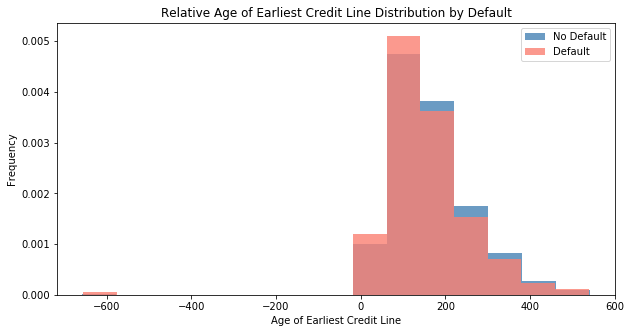

In [40]:
ax = data['age_of_earliest_cr_line'].loc[data['default'] == 0].plot.hist(bins=15, density = True, alpha=0.8, label='No Default', figsize = (10,5),color='steelblue')
ax = data['age_of_earliest_cr_line'].loc[data['default'] == 1].plot.hist(bins=15, density = True, alpha=0.8, label='Default', figsize = (10,5),color='salmon')
ax.set_xlabel('Age of Earliest Credit Line')
ax.set_title('Relative Age of Earliest Credit Line Distribution by Default')
ax.legend();

## Problem with variable zip_code -> just deleting it for now

In [41]:
data = data.drop(['zip_code'], axis=1)

## Categorize variable emp_title

In [42]:
data['emp_title'] = data['emp_title'].fillna('NO_VALUE')
def emp_title_category(row):
    if row['emp_title'] == "NO_VALUE" and row['emp_length'] > 0:
        return "Employed"
    elif row['emp_title'] == "NO_VALUE" and row['emp_length'] == 0:
        return "Unemployed"
    else:
        return "Employed"

data = data.assign(emp_title_new=data.apply(emp_title_category, axis=1))

## Default and Employment Status

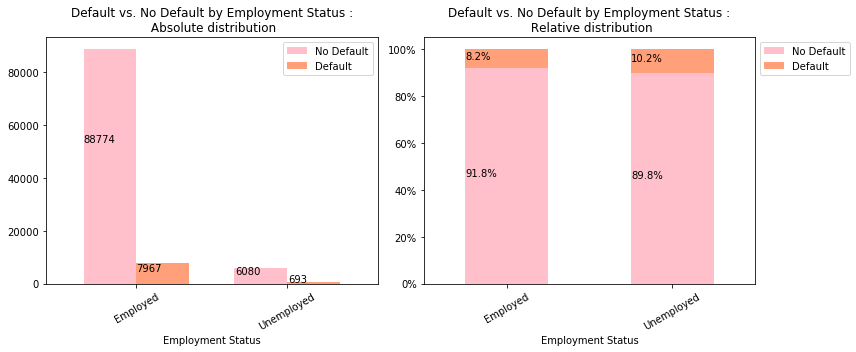

In [43]:
fig = plt.figure(figsize=(12, 5)) #specify figure size

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = data.groupby(['emp_title_new', 'default'])['default'].count().unstack().plot.bar(rot=30, ax=plt.gca(), width=0.7, color=['pink','lightsalmon'])
plt.title('Default vs. No Default by Employment Status :\n Absolute distribution') 
L = plt.legend()
L.get_texts()[0].set_text('No Default')
L.get_texts()[1].set_text('Default')
ax1.set_xlabel('Employment Status')
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 0.605))

#Relative distribution
plt.subplot(1, 2, 2)
ax2 = data.groupby(['emp_title_new','default'])['default'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=30, ax=plt.gca(), color=['pink','lightsalmon'])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Default vs. No Default by Employment Status :\n Relative distribution') 
L = plt.legend(bbox_to_anchor=(1, 1))
L.get_texts()[0].set_text('No Default')
L.get_texts()[1].set_text('Default')
ax2.set_xlabel('Employment Status')
#plot bar labels
for p, q in zip(ax2.patches[0:2], ax2.patches[2:4]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x(), p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x(), q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

In [44]:
data=pd.get_dummies(data, columns=['emp_title_new'])
data=data.drop(['emp_title'], axis=1)

## Categorize variables mths_since_last_delinq and mths_since_last_record

In [45]:
data['mths_since_last_delinq'] = data['mths_since_last_delinq'].fillna('10000')
data['mths_since_last_record'] = data['mths_since_last_record'].fillna('10000')
data['mths_since_last_delinq']=data['mths_since_last_delinq'].astype(int)
data['mths_since_last_record']=data['mths_since_last_record'].astype(int)
data.tail(10).style

,loan_amnt,installment,emp_length,home_ownership,annual_inc,verification_status,title,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,default,term_new,age_of_earliest_cr_line,emp_title_new_Employed,emp_title_new_Unemployed
103504,23800,559.85,20,MORTGAGE,119000,Not Verified,Debt consolidation,OH,32.73,0,1,10000,10000,13,0,0,60,258,1,0
103505,18000,377.95,5,OWN,130000,Not Verified,Home improvement,TX,20.59,0,1,10000,10000,17,0,0,60,115,1,0
103506,40000,859.56,5,MORTGAGE,150000,Verified,Debt consolidation,FL,15.47,0,0,10000,10000,7,0,0,60,189,1,0
103507,29400,683.94,9,MORTGAGE,180792,Not Verified,Debt consolidation,CA,22.03,0,1,10000,10000,16,0,0,60,143,1,0
103508,32000,752.74,3,MORTGAGE,157000,Source Verified,Home improvement,AZ,10.34,0,0,10000,10000,14,0,1,60,32,1,0
103509,16000,362.34,19,RENT,150000,Not Verified,Medical expenses,NC,12.25,0,0,68,26,12,4,0,60,198,1,0
103510,24000,515.74,4,OWN,125000,Not Verified,Credit card refinancing,HI,10.98,0,0,10000,42,15,2,0,60,156,1,0
103511,24000,543.5,7,MORTGAGE,95000,Source Verified,Home improvement,AL,19.61,0,0,10000,10000,5,0,0,60,170,1,0
103512,24000,515.74,19,MORTGAGE,108000,Not Verified,Debt consolidation,UT,34.94,0,1,60,69,24,1,0,60,276,1,0
103513,24000,564.56,6,RENT,110000,Not Verified,Debt consolidation,FL,18.3,0,0,67,72,10,1,1,60,175,1,0


## Dummy encoding for home_ownership, verification_status, title, addr_state

In [46]:
data = pd.get_dummies(data, columns=['home_ownership', 'verification_status', 'title'])
data.head().style

,loan_amnt,installment,emp_length,annual_inc,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,default,term_new,age_of_earliest_cr_line,emp_title_new_Employed,emp_title_new_Unemployed,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,title_Business,title_Car financing,title_Credit card refinancing,title_Debt consolidation,title_Green loan,title_Home buying,title_Home improvement,title_Major purchase,title_Medical expenses,title_Moving and relocation,title_Other,title_Vacation
0,14400,291.92,9,135000,NJ,6.6,1,0,11,10000,15,0,0,60,172,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,4500,151.06,6,32000,WI,29.93,0,1,10000,10000,7,0,0,36,34,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3600,118.53,11,89712,WA,20.3,0,0,10000,10000,16,0,0,36,234,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,7000,210.81,2,85000,NY,12.8,1,0,20,30,14,1,0,36,264,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,39000,1370.94,19,78000,OH,33.14,0,0,10000,10000,17,0,0,36,165,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0


In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103514 entries, 0 to 103513
Data columns (total 36 columns):
loan_amnt                              103514 non-null int64
installment                            103514 non-null float64
emp_length                             103514 non-null float64
annual_inc                             103514 non-null float64
addr_state                             103514 non-null object
dti                                    103514 non-null float64
delinq_2yrs                            103514 non-null int64
inq_last_6mths                         103514 non-null int64
mths_since_last_delinq                 103514 non-null int64
mths_since_last_record                 103514 non-null int64
open_acc                               103514 non-null int64
pub_rec                                103514 non-null int64
default                                103514 non-null int64
term_new                               103514 non-null int64
age_of_earliest_cr_line   

In [48]:
#grouping the states into 4 groups: northeast= ME, NH, VT, MA, RI, CT, NJ, NY, PA
#MIDWEST= ND, SD, NE, KS, MN, IA, MO, WI, IL, MI, IN, OH
#SOUTH = OK, TX, AR, LA, KY, TN, MS, AL, FL, GA, SC, NC, VA,WV, MD, DC, DE
#WEST=WA, ID, MT, OR, WY, CA, NV, UT, CO, AZ, NM, AK, HI

In [49]:
data.addr_state.unique()

array(['NJ', 'WI', 'WA', 'NY', 'OH', 'MA', 'KS', 'MI', 'FL', 'NV', 'IN',
       'CT', 'CA', 'GA', 'OK', 'LA', 'AZ', 'CO', 'MO', 'IL', 'MD', 'TN',
       'TX', 'NE', 'UT', 'OR', 'ND', 'NC', 'MS', 'AR', 'AL', 'MN', 'PA',
       'VA', 'RI', 'DE', 'WY', 'NH', 'KY', 'HI', 'SC', 'MT', 'ID', 'ME',
       'VT', 'AK', 'NM', 'DC', 'SD'], dtype=object)

In [50]:
#NORTHEAST
def northeast(row):
    if row['addr_state'] == 'ME' :
        return 'north_east'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(northeast, axis=1))

def northeast(row):
    if row['addr_state'] == 'NH' :
        return 'north_east'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(northeast, axis=1))


def northeast(row):
    if row['addr_state'] == 'VT' :
        return 'north_east'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(northeast, axis=1))

def northeast(row):
    if row['addr_state'] == 'MA' :
        return 'north_east'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(northeast, axis=1))

def northeast(row):
    if row['addr_state'] == 'RI' :
        return 'north_east'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(northeast, axis=1))

def northeast(row):
    if row['addr_state'] == 'CT' :
        return 'north_east'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(northeast, axis=1))

def northeast(row):
    if row['addr_state'] == 'NJ' :
        return 'north_east'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(northeast, axis=1))

def northeast(row):
    if row['addr_state'] == 'NY' :
        return 'north_east'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(northeast, axis=1))

def northeast(row):
    if row['addr_state'] == 'PA' :
        return 'north_east'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(northeast, axis=1))


In [51]:
#MIDWEST

def midwest(row):
    if row['addr_state'] == 'ND' :
        return 'mid_west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'SD' :
        return 'mid_west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'NE' :
        return 'mid_west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'KS' :
        return 'mid_west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'MN' :
        return 'mid_west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'IA' :
        return 'mid_west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'MO' :
        return 'mid_west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'WI' :
        return 'mid_west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'IL' :
        return 'mid_west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'MI' :
        return 'mid_west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'IN' :
        return 'mid_west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'OH' :
        return 'mid_west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(midwest, axis=1))

In [52]:
#SOUTH
def South(row):
    if row['addr_state'] == 'OK' :
        return 'south'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'TX' :
        return 'south'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'AR' :
        return 'south'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'LA' :
        return 'south'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'KY' :
        return 'south'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'TN' :
        return 'south'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'MS' :
        return 'south'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'AL' :
        return 'south'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'FL' :
        return 'south'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'GA' :
        return 'south'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'SC' :
        return 'south'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'NC' :
        return 'south'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'VA' :
        return 'south'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'WV' :
        return 'south'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'MD' :
        return 'south'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'DC' :
        return 'south'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'DE' :
        return 'south'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(South, axis=1))

In [53]:
def West(row):
    if row['addr_state'] == 'WA' :
        return 'west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'ID' :
        return 'west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'MT' :
        return 'west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'OR' :
        return 'west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'WY' :
        return 'west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'CA' :
        return 'west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'NV' :
        return 'west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'UT' :
        return 'west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'CO' :
        return 'west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'AZ' :
        return 'west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'NM' :
        return 'west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'AK' :
        return 'west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'HI' :
        return 'west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(West, axis=1))

In [54]:
data.addr_state.unique()

array(['north_east', 'mid_west', 'west', 'south'], dtype=object)

In [55]:
data.head()

,loan_amnt,installment,emp_length,annual_inc,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,...,title_Credit card refinancing,title_Debt consolidation,title_Green loan,title_Home buying,title_Home improvement,title_Major purchase,title_Medical expenses,title_Moving and relocation,title_Other,title_Vacation
0,14400,291.92,9.0,135000.0,north_east,6.60,1,0,11,10000,...,0,0,0,0,1,0,0,0,0,0
1,4500,151.06,6.0,32000.0,mid_west,29.93,0,1,10000,10000,...,1,0,0,0,0,0,0,0,0,0
2,3600,118.53,11.0,89712.0,west,20.30,0,0,10000,10000,...,1,0,0,0,0,0,0,0,0,0
3,7000,210.81,2.0,85000.0,north_east,12.80,1,0,20,30,...,0,1,0,0,0,0,0,0,0,0
4,39000,1370.94,19.0,78000.0,mid_west,33.14,0,0,10000,10000,...,0,1,0,0,0,0,0,0,0,0


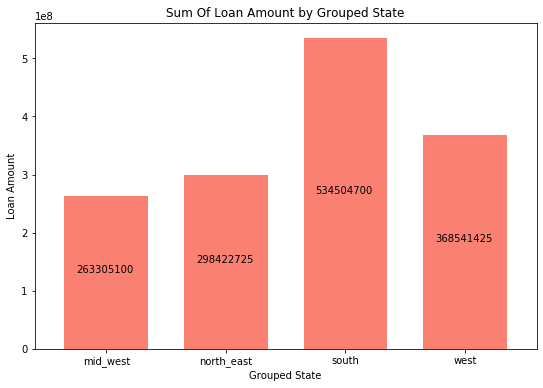

In [56]:
fig = plt.figure(figsize=(9, 6)) #specify figure size

ax1=data.groupby(['addr_state'])['loan_amnt'].sum().plot.bar(rot=0, color='salmon', ax=plt.gca(), width=0.7)
plt.title('Sum of loans by state') 
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() + 0.1, p.get_height()/2))
plt.xlabel('Grouped State')
plt.ylabel('Loan Amount')
plt.title('Sum Of Loan Amount by Grouped State') 
    
plt.show()

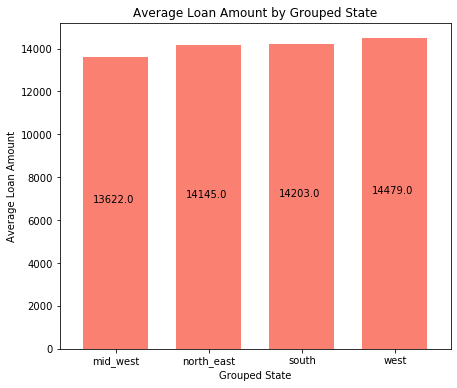

In [57]:
fig = plt.figure(figsize=(7, 6)) #specify figure size

ax1=data.groupby(['addr_state'])['loan_amnt'].mean().round().plot.bar(rot=0, color='salmon', ax=plt.gca(), width=0.7)
plt.title('Sum of loans by state') 
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() + 0.1, p.get_height()/2))
plt.xlabel('Grouped State')
plt.ylabel('Average Loan Amount')
plt.title('Average Loan Amount by Grouped State') 
    
plt.show()

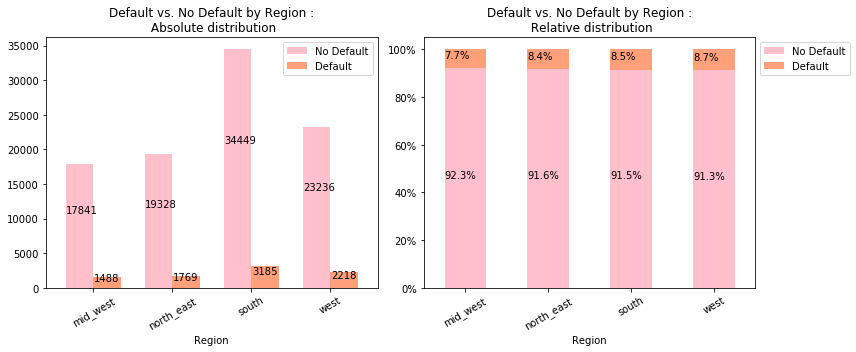

In [58]:
fig = plt.figure(figsize=(12, 5)) #specify figure size

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = data.groupby(['addr_state', 'default'])['default'].count().unstack().plot.bar(rot=30, ax=plt.gca(), width=0.7, color=['pink','lightsalmon'])
plt.title('Default vs. No Default by Region :\n Absolute distribution') 
L = plt.legend()
L.get_texts()[0].set_text('No Default')
L.get_texts()[1].set_text('Default')
ax1.set_xlabel('Region')
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 0.605))

#Relative distribution
plt.subplot(1, 2, 2)
ax2 = data.groupby(['addr_state','default'])['default'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=30, ax=plt.gca(), color=['pink','lightsalmon'])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Default vs. No Default by Region :\n Relative distribution') 
L = plt.legend(bbox_to_anchor=(1, 1))
L.get_texts()[0].set_text('No Default')
L.get_texts()[1].set_text('Default')
ax2.set_xlabel('Region')
#plot bar labels
for p, q in zip(ax2.patches[0:4], ax2.patches[4:8]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x(), p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x(), q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

In [59]:
print('South proportion in default: ' + str(round(3185/8660, 5)))

South proportion in default: 0.36778


In [60]:
data=pd.get_dummies(data, columns=['addr_state'])

In [61]:
data.head()

,loan_amnt,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,...,title_Home improvement,title_Major purchase,title_Medical expenses,title_Moving and relocation,title_Other,title_Vacation,addr_state_mid_west,addr_state_north_east,addr_state_south,addr_state_west
0,14400,291.92,9.0,135000.0,6.60,1,0,11,10000,15,...,1,0,0,0,0,0,0,1,0,0
1,4500,151.06,6.0,32000.0,29.93,0,1,10000,10000,7,...,0,0,0,0,0,0,1,0,0,0
2,3600,118.53,11.0,89712.0,20.30,0,0,10000,10000,16,...,0,0,0,0,0,0,0,0,0,1
3,7000,210.81,2.0,85000.0,12.80,1,0,20,30,14,...,0,0,0,0,0,0,0,1,0,0
4,39000,1370.94,19.0,78000.0,33.14,0,0,10000,10000,17,...,0,0,0,0,0,0,1,0,0,0


In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103514 entries, 0 to 103513
Data columns (total 39 columns):
loan_amnt                              103514 non-null int64
installment                            103514 non-null float64
emp_length                             103514 non-null float64
annual_inc                             103514 non-null float64
dti                                    103514 non-null float64
delinq_2yrs                            103514 non-null int64
inq_last_6mths                         103514 non-null int64
mths_since_last_delinq                 103514 non-null int64
mths_since_last_record                 103514 non-null int64
open_acc                               103514 non-null int64
pub_rec                                103514 non-null int64
default                                103514 non-null int64
term_new                               103514 non-null int64
age_of_earliest_cr_line                103514 non-null int64
emp_title_new_Employed     

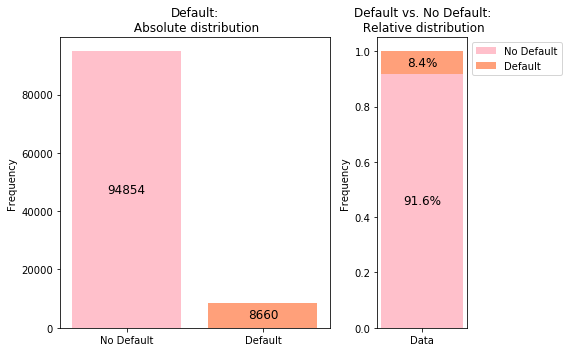

In [63]:
keys, counts = np.unique(data.default, return_counts=True)
counts_norm = counts/counts.sum()

fig = plt.figure(figsize=(8, 5)) #specify figure size
gs = gridspec.GridSpec(1, 2, width_ratios=[3,1]) #specify relative size of left and right plot

#Absolute values
ax0 = plt.subplot(gs[0])
ax0 = plt.bar(['No Default', 'Default'], 
              counts, color=['pink','lightsalmon']) #left bar plot
ax0 = plt.title('Default:\n Absolute distribution') 
ax0 = plt.ylabel('Frequency')
ax0 = plt.text(['No Default'], counts[0]/2, counts[0],  fontsize=12, horizontalalignment='center', verticalalignment='center') 
ax0 = plt.text(['Default'], counts[1]/2, counts[1],  fontsize=12, horizontalalignment='center', verticalalignment='center')

#Normalized values
ax1 = plt.subplot(gs[1])
ax1 = plt.bar(['Data'], [counts_norm[0]], label='No Default', color=['pink'])
ax1 = plt.bar(['Data'], [counts_norm[1]], bottom=counts_norm[0], label='Default', color=['lightsalmon'])
ax1 = plt.legend(bbox_to_anchor=(1, 1))
ax1 = plt.title('Default vs. No Default:\n Relative distribution')
ax1 = plt.ylabel('Frequency')
ax1 = plt.text(['Data'],counts_norm[0]/2, '{}%'.format((counts_norm[0]*100).round(1)), fontsize=12, horizontalalignment='center', verticalalignment='center')
ax1 = plt.text(['Data'],(counts_norm[1]/2)+counts_norm[0], '{}%'.format((counts_norm[1]*100).round(1)), fontsize=12, horizontalalignment='center', verticalalignment='center')

plt.tight_layout()
plt.show()

In [64]:
#data.groupby(['addr_state_mid_west', 'default'])['default'].count()
#data.groupby(['addr_state_north_east', 'default'])['default'].sum()
#data.groupby(['addr_state_south', 'default'])['default'].count()
#data.groupby(['addr_state_west', 'default'])['default'].count()

# Testing Data

In [65]:
data_test_withint = pd.read_csv('LC_TestData_2020.csv')
data_test_withint['int_rate'] = list(map(lambda x: x[:-1], data_test_withint['int_rate'].values))
data_test_withint['int_rate'] = [float(x) for x in data_test_withint['int_rate'].values]
data_test_withint['int_rate'] = data_test_withint['int_rate'] / 100
data_test = pd.read_csv('LC_TestData_2020.csv')
data_test.head().style

,loan_amnt,term,int_rate,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,Unnamed: 21
0,15000,36 months,5.32 %,451.73,Executive Account Manager,16,MORTGAGE,182000,Not Verified,Current,Debt consolidation,751xx,TX,9.35,0,Nov.74,0,nan,nan,13,0,nan
1,17000,36 months,7.49 %,528.73,Air Traffic Controller,20,MORTGAGE,120000,Not Verified,Fully Paid,Debt consolidation,840xx,UT,8.41,0,Oct.05,0,72,89,9,1,nan
2,20000,36 months,5.32 %,602.3,Associate Dentist,3,RENT,120000,Not Verified,Current,Credit card refinancing,926xx,CA,26.54,0,Aug.02,1,nan,nan,18,0,nan
3,16000,60 months,12.74 %,361.93,claims analyst,19,MORTGAGE,130000,Not Verified,Current,Debt consolidation,577xx,SD,8.28,0,Jul.95,0,42,79,16,1,nan
4,2000,36 months,16.99 %,71.3,Supervisor,6,MORTGAGE,62000,Not Verified,Current,Credit card refinancing,983xx,WA,16.43,0,Oct.07,2,57,44,10,2,nan


In [66]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96745 entries, 0 to 96744
Data columns (total 22 columns):
loan_amnt                 96745 non-null int64
term                      96745 non-null object
int_rate                  96745 non-null object
installment               96745 non-null float64
emp_title                 89884 non-null object
emp_length                96745 non-null float64
home_ownership            96745 non-null object
annual_inc                96745 non-null float64
verification_status       96745 non-null object
loan_status               96745 non-null object
title                     96745 non-null object
zip_code                  96745 non-null object
addr_state                96745 non-null object
dti                       96745 non-null float64
delinq_2yrs               96745 non-null int64
earliest_cr_line          96745 non-null object
inq_last_6mths            96745 non-null int64
mths_since_last_delinq    50474 non-null float64
mths_since_last_record   

In [67]:
data_test.describe().round()

,loan_amnt,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,Unnamed: 21
count,96745.0,96745.0,96745.0,96745.0,96745.0,96745.0,96745.0,50474.0,19099.0,96745.0,96745.0,0.0
mean,14856.0,451.0,8.0,82790.0,19.0,0.0,1.0,34.0,69.0,12.0,0.0,NaN
std,9395.0,283.0,6.0,214976.0,13.0,1.0,1.0,22.0,26.0,6.0,1.0,NaN
min,1000.0,30.0,0.0,400.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN
25%,7800.0,244.0,2.0,49000.0,12.0,0.0,0.0,15.0,52.0,8.0,0.0,NaN
50%,12000.0,373.0,5.0,70000.0,18.0,0.0,0.0,30.0,72.0,11.0,0.0,NaN
75%,20000.0,602.0,13.0,99500.0,24.0,0.0,1.0,49.0,87.0,15.0,0.0,NaN
max,40000.0,1715.0,20.0,61000000.0,999.0,21.0,5.0,137.0,120.0,72.0,61.0,NaN


In [68]:
data_test = data_test.assign(default=data_test.apply(default_category, axis=1))
data_test.tail().style

,loan_amnt,term,int_rate,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,Unnamed: 21,default
96740,10400,36 months,14.99 %,360.47,Glaze Operator,5,RENT,26000,Source Verified,Current,Debt consolidation,657xx,MO,18.56,0,marras.06,0,nan,nan,3,0,nan,0
96741,15000,36 months,12.74 %,503.54,Senior Product Manager,2,RENT,110500,Source Verified,Current,Credit card refinancing,802xx,CO,4.95,0,Feb.11,2,nan,nan,13,0,nan,0
96742,10000,36 months,8.24 %,314.48,nan,0,MORTGAGE,46203,Not Verified,Current,Debt consolidation,342xx,FL,17.04,0,Nov.02,0,38,nan,8,0,nan,0
96743,6325,36 months,15.99 %,222.34,nan,0,OWN,24564,Not Verified,Current,Debt consolidation,183xx,PA,21.38,2,Oct.86,0,15,nan,12,0,nan,0
96744,15625,60 months,28.69 %,493.03,Certified Dietary Manager,1,RENT,34000,Source Verified,Current,Debt consolidation,834xx,ID,32.4,0,Apr.05,0,68,52,13,1,nan,0


In [69]:
data_test = data_test.drop(['loan_status', 'Unnamed: 21'], axis=1)
data_test = data_test.loc[:, data_test.columns != 'int_rate']
data_test.head().style

,loan_amnt,term,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,default
0,15000,36 months,451.73,Executive Account Manager,16,MORTGAGE,182000,Not Verified,Debt consolidation,751xx,TX,9.35,0,Nov.74,0,nan,nan,13,0,0
1,17000,36 months,528.73,Air Traffic Controller,20,MORTGAGE,120000,Not Verified,Debt consolidation,840xx,UT,8.41,0,Oct.05,0,72,89,9,1,0
2,20000,36 months,602.3,Associate Dentist,3,RENT,120000,Not Verified,Credit card refinancing,926xx,CA,26.54,0,Aug.02,1,nan,nan,18,0,0
3,16000,60 months,361.93,claims analyst,19,MORTGAGE,130000,Not Verified,Debt consolidation,577xx,SD,8.28,0,Jul.95,0,42,79,16,1,0
4,2000,36 months,71.3,Supervisor,6,MORTGAGE,62000,Not Verified,Credit card refinancing,983xx,WA,16.43,0,Oct.07,2,57,44,10,2,0


## Default and Home Ownership

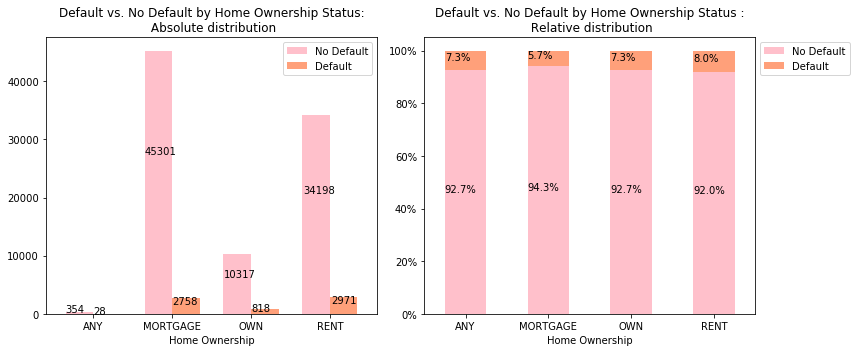

In [70]:
data_test['home_ownership'] = data_test['home_ownership'].replace('NONE', 'ANY')

fig = plt.figure(figsize=(12, 5)) #specify figure size

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = data_test.groupby(['home_ownership', 'default'])['default'].count().unstack().plot.bar(rot=0, ax=plt.gca(), width=0.7, color=['pink','lightsalmon'])
plt.title('Default vs. No Default by Home Ownership Status:\n Absolute distribution') 
L = plt.legend()
L.get_texts()[0].set_text('No Default')
L.get_texts()[1].set_text('Default')
ax1.set_xlabel('Home Ownership')
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 0.605))

#Relative distribution
plt.subplot(1, 2, 2)
ax2 = data_test.groupby(['home_ownership','default'])['default'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=0, ax=plt.gca(), color=['pink','lightsalmon'])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
L = plt.legend(bbox_to_anchor=(1, 1))
L.get_texts()[0].set_text('No Default')
L.get_texts()[1].set_text('Default')
plt.title('Default vs. No Default by Home Ownership Status :\n Relative distribution') 
ax2.set_xlabel('Home Ownership')
#plot bar labels
for p, q in zip(ax2.patches[0:4], ax2.patches[4:8]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x(), p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x(), q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

In [71]:
print('Mortgage proportion in default: ' + str(round(2758/6900,5)))

Mortgage proportion in default: 0.39971


## Default and Verification Status

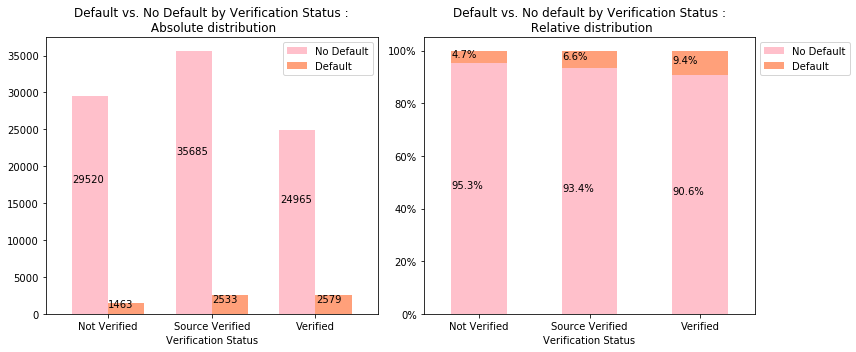

In [72]:
fig = plt.figure(figsize=(12, 5)) #specify figure size

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = data_test.groupby(['verification_status', 'default'])['default'].count().unstack().plot.bar(rot=0, ax=plt.gca(), width=0.7, color=['pink','lightsalmon'])
plt.title('Default vs. No Default by Verification Status :\n Absolute distribution') 
L = plt.legend()
L.get_texts()[0].set_text('No Default')
L.get_texts()[1].set_text('Default')
ax1.set_xlabel('Verification Status')
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 0.605))

#Relative distribution
plt.subplot(1, 2, 2)
ax2 = data_test.groupby(['verification_status','default'])['default'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=0, ax=plt.gca(), color=['pink','lightsalmon'])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Default vs. No default by Verification Status :\n Relative distribution') 
L = plt.legend(bbox_to_anchor=(1, 1))
L.get_texts()[0].set_text('No Default')
L.get_texts()[1].set_text('Default')
ax2.set_xlabel('Verification Status')
#plot bar labels
for p, q in zip(ax2.patches[0:3], ax2.patches[3:6]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x(), p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x(), q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

In [73]:
print('Not Verified proportion in default: ' + str(round(1463/6575,5)))

Not Verified proportion in default: 0.22251


## Default and Title

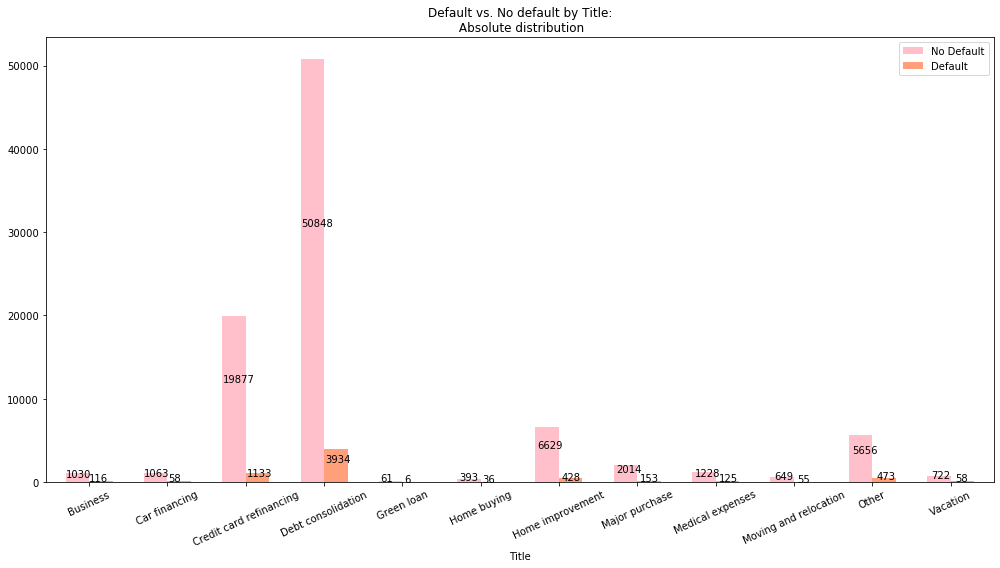

In [74]:
fig = plt.figure(figsize=(14, 8)) #specify figure size

#Absolute distribution
ax1 = data_test.groupby(['title', 'default'])['default'].count().unstack().plot.bar(rot=25, ax=plt.gca(), width=0.6, color=['pink','lightsalmon'])
plt.title('Default vs. No default by Title:\n Absolute distribution') 
L = plt.legend()
L.get_texts()[0].set_text('No Default')
L.get_texts()[1].set_text('Default')
ax1.set_xlabel('Title')
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 0.605))

plt.tight_layout()
plt.show()

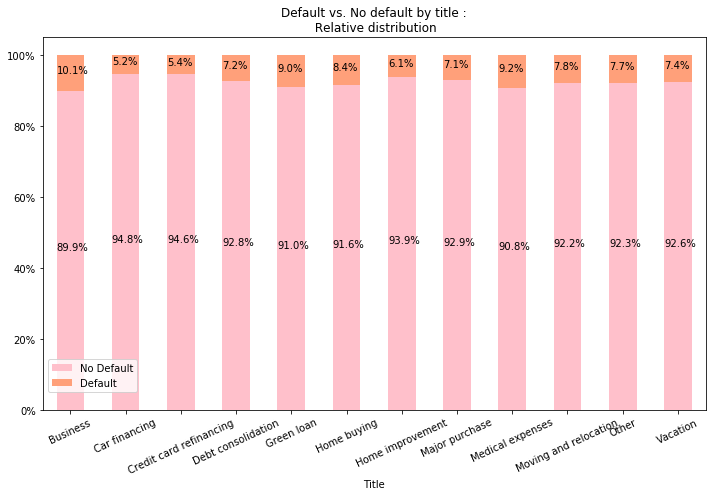

In [75]:
ax2 = data_test.groupby(['title','default'])['default'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=25, ax=plt.gca(), color=['pink','lightsalmon'], figsize=(10,7))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Default vs. No default by title :\n Relative distribution') 
L = plt.legend(bbox_to_anchor=(0.15, 0.15))
L.get_texts()[0].set_text('No Default')
L.get_texts()[1].set_text('Default')
ax2.set_xlabel('Title')
#plot bar labels
for p, q in zip(ax2.patches[0:12], ax2.patches[12:24]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x(), p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x(), q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

In [76]:
print('Credit card refinancing proportion in default: ' + str(round(1133/6575, 5)))

Credit card refinancing proportion in default: 0.17232


## Default and Addr_state (no grouping)

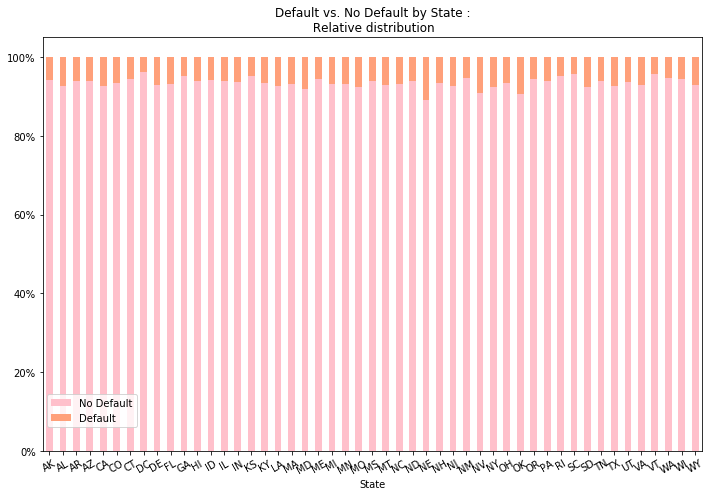

In [77]:
ax2 = data_test.groupby(['addr_state','default'])['default'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=30, ax=plt.gca(), color=['pink','lightsalmon'], figsize=(10,7))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Default vs. No Default by State :\n Relative distribution') 
L = plt.legend(bbox_to_anchor=(0.15, 0.15))
L.get_texts()[0].set_text('No Default')
L.get_texts()[1].set_text('Default')
ax2.set_xlabel('State')
#plot bar labels
#for p, q in zip(ax2.patches[0:48], ax2.patches[49:97]):
#    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x(), p.get_height()/2))
#    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x(), q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

In [78]:
loan_by_state = pd.DataFrame(data_test.groupby("addr_state")["loan_amnt"].sum())
loan_by_state = loan_by_state.sort_values(by=['loan_amnt'], ascending=True) 
loan_by_state = loan_by_state.reset_index()

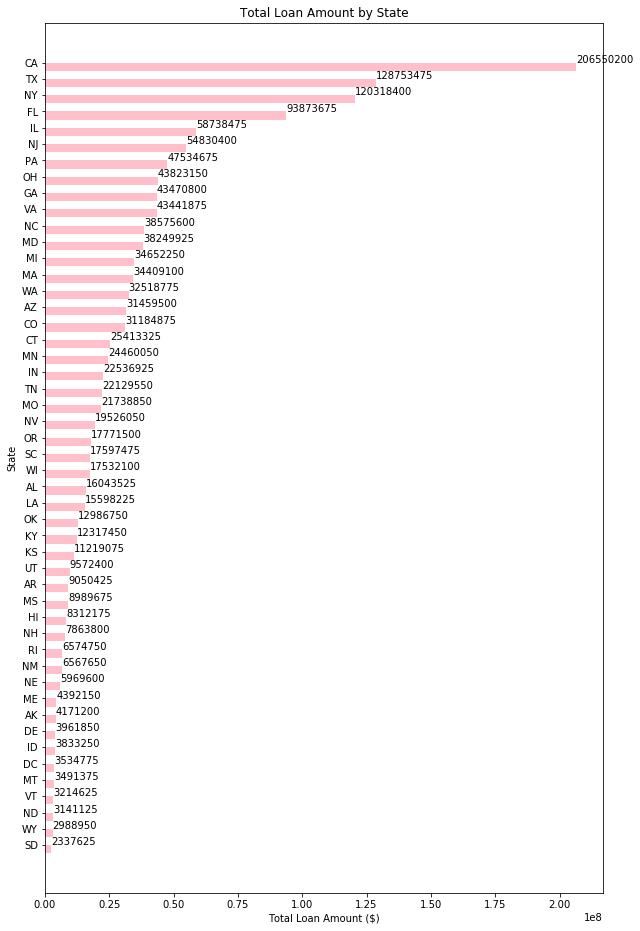

In [79]:
x = np.array(loan_by_state['addr_state'])
y = np.array(loan_by_state['loan_amnt'])

fig, ax = plt.subplots(figsize=(10, 16))    
width = 0.5 # the width of the bars 
ind = np.arange(len(x))  # the x locations for the groups
ax.barh(ind, y, width, color="pink")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title('Total Loan Amount by State')
plt.ylabel('State')
plt.xlabel('Total Loan Amount ($)')   

for i, v in enumerate(y):
    ax.text(v + 3, i + .25, str(v))

plt.show()

## Default and Loan Amount

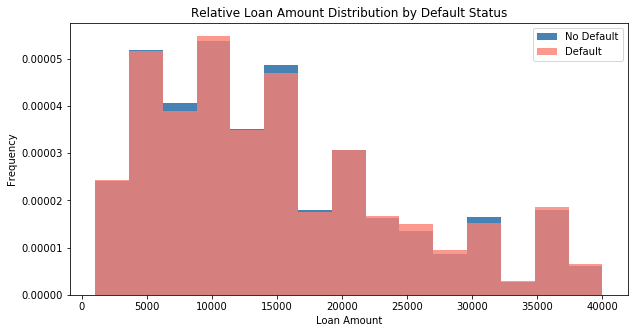

In [80]:
ax = data_test['loan_amnt'].loc[data['default'] == 0].plot.hist(bins=15, density = True, label='No Default', figsize = (10,5),color='steelblue')
ax = data_test['loan_amnt'].loc[data['default'] == 1].plot.hist(bins=15, density = True, alpha=0.8, label='Default', figsize = (10,5),color='salmon')
ax.set_xlabel('Loan Amount')
ax.set_title('Relative Loan Amount Distribution by Default Status')
ax.legend()

## Default and Annual Income

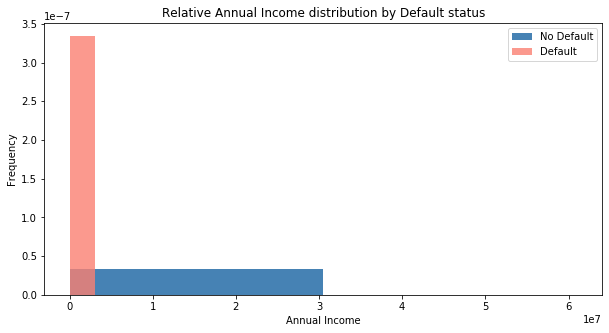

In [81]:
ax = data_test['annual_inc'].loc[data['default'] == 0].plot.hist(bins=2, density = True, label='No Default', figsize = (10,5),color='steelblue')
ax = data_test['annual_inc'].loc[data['default'] == 1].plot.hist(bins=2, density = True, alpha=0.8, label='Default', figsize = (10,5),color='salmon')
ax.set_xlabel('Annual Income')
ax.set_title('Relative Annual Income distribution by Default status')
ax.legend();

## Default and Employment Length

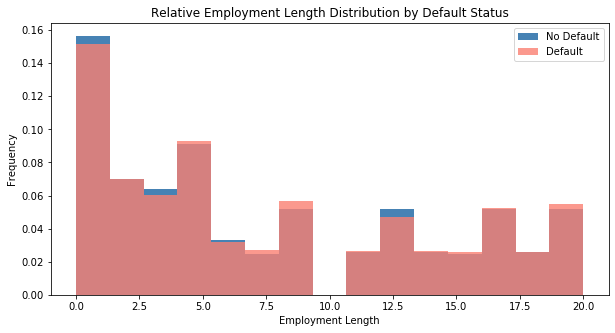

In [82]:
ax = data_test['emp_length'].loc[data['default'] == 0].plot.hist(bins=15, density = True, label='No Default', figsize = (10,5),color='steelblue')
ax = data_test['emp_length'].loc[data['default'] == 1].plot.hist(bins=15, density = True, alpha=0.8, label='Default', figsize = (10,5),color='salmon')
ax.set_xlabel('Employment Length')
ax.set_title('Relative Employment Length Distribution by Default Status')
ax.legend();

## Default and Installment

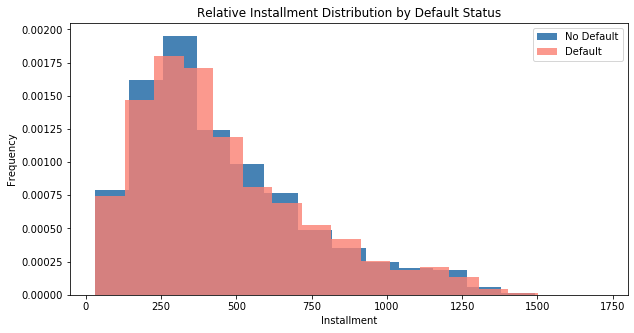

In [83]:
ax = data_test['installment'].loc[data['default'] == 0].plot.hist(bins=15, density = True, label='No Default', figsize = (10,5),color='steelblue')
ax = data_test['installment'].loc[data['default'] == 1].plot.hist(bins=15, density = True, alpha=0.8, label='Default', figsize = (10,5),color='salmon')
ax.set_xlabel('Installment')
ax.set_title('Relative Installment Distribution by Default Status')
ax.legend();

## Default and Open Account

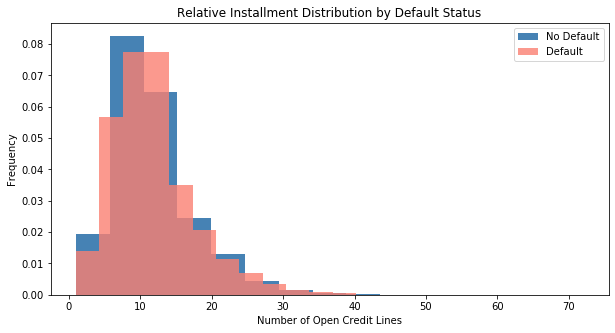

In [84]:
ax = data_test['open_acc'].loc[data['default'] == 0].plot.hist(bins=15, density = True, label='No Default', figsize = (10,5),color='steelblue')
ax = data_test['open_acc'].loc[data['default'] == 1].plot.hist(bins=15, density = True, alpha=0.8, label='Default', figsize = (10,5),color='salmon')
ax.set_xlabel('Number of Open Credit Lines')
ax.set_title('Relative Installment Distribution by Default Status')
ax.legend();

## Default and dti (dti <= 80 -> 96629 out of 96745)

In [85]:
data2=data_test[data_test.dti <= 80]
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96629 entries, 0 to 96744
Data columns (total 20 columns):
loan_amnt                 96629 non-null int64
term                      96629 non-null object
installment               96629 non-null float64
emp_title                 89813 non-null object
emp_length                96629 non-null float64
home_ownership            96629 non-null object
annual_inc                96629 non-null float64
verification_status       96629 non-null object
title                     96629 non-null object
zip_code                  96629 non-null object
addr_state                96629 non-null object
dti                       96629 non-null float64
delinq_2yrs               96629 non-null int64
earliest_cr_line          96629 non-null object
inq_last_6mths            96629 non-null int64
mths_since_last_delinq    50408 non-null float64
mths_since_last_record    19077 non-null float64
open_acc                  96629 non-null int64
pub_rec                  

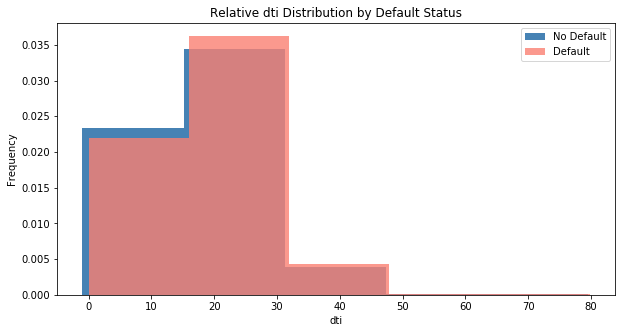

In [86]:
ax = data2['dti'].loc[data2['default'] == 0].plot.hist(bins=5, density = True, label='No Default', figsize = (10,5),color='steelblue')
ax = data2['dti'].loc[data2['default'] == 1].plot.hist(bins=5, density = True, alpha=0.8, label='Default', figsize = (10,5),color='salmon')
ax.set_xlabel('dti')
ax.set_title('Relative dti Distribution by Default Status')
ax.legend();

## Defaul and Term

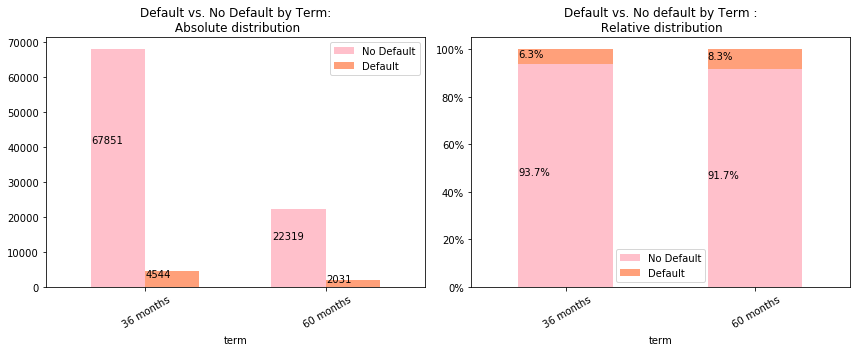

In [87]:
fig = plt.figure(figsize=(12, 5)) #specify figure size

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = data_test.groupby(['term', 'default'])['default'].count().unstack().plot.bar(rot=30, ax=plt.gca(), width=0.6, color=['pink','lightsalmon'])
plt.title('Default vs. No Default by Term:\n Absolute distribution') 
L = plt.legend()
L.get_texts()[0].set_text('No Default')
L.get_texts()[1].set_text('Default')
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 0.605))

#Relative distribution
plt.subplot(1, 2, 2)
ax2 = data_test.groupby(['term','default'])['default'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=30, ax=plt.gca(), color=['pink','lightsalmon'])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
L = plt.legend()
L.get_texts()[0].set_text('No Default')
L.get_texts()[1].set_text('Default')
plt.title('Default vs. No default by Term :\n Relative distribution') 
#plot bar labels
for p, q in zip(ax2.patches[0:2], ax2.patches[2:4]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x(), p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x(), q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

## Loan Amount and Annual Income

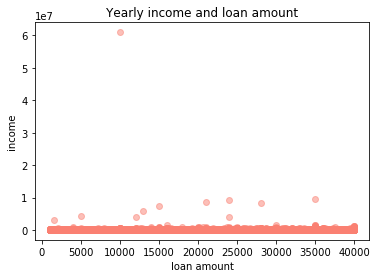

In [88]:
x=data_test['loan_amnt']
y=data_test['annual_inc']

plt.scatter(x, y, color='salmon', alpha=0.5)
plt.title('Yearly income and loan amount')
plt.xlabel('loan amount')
plt.ylabel('income')
plt.show()

In [89]:
new2= data_test["term"].str.split(" ", n = -1, expand = True)
data_test["term_new"]=new2[1]  
data_test["useless"]= new2[2] 
data_test = data_test.drop(['useless'], axis=1)
data_test['term_new']=data_test['term_new'].astype(int)
data_test=data_test.drop(['term'], axis=1)
data_test.head().style

,loan_amnt,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,default,term_new
0,15000,451.73,Executive Account Manager,16,MORTGAGE,182000,Not Verified,Debt consolidation,751xx,TX,9.35,0,Nov.74,0,nan,nan,13,0,0,36
1,17000,528.73,Air Traffic Controller,20,MORTGAGE,120000,Not Verified,Debt consolidation,840xx,UT,8.41,0,Oct.05,0,72,89,9,1,0,36
2,20000,602.3,Associate Dentist,3,RENT,120000,Not Verified,Credit card refinancing,926xx,CA,26.54,0,Aug.02,1,nan,nan,18,0,0,36
3,16000,361.93,claims analyst,19,MORTGAGE,130000,Not Verified,Debt consolidation,577xx,SD,8.28,0,Jul.95,0,42,79,16,1,0,60
4,2000,71.3,Supervisor,6,MORTGAGE,62000,Not Verified,Credit card refinancing,983xx,WA,16.43,0,Oct.07,2,57,44,10,2,0,36


In [90]:
data_test[['earliest_cr_Month','earliest_cr_Year']] = data_test.earliest_cr_line.str.split(".",expand=True,)

In [91]:
data_test = data_test.assign(earliest_cr_Day=data_test.apply(new_column_earliest_cr_Day, axis=1))

In [92]:
data_test = data_test.assign(earliest_cr_Month=data_test.apply(marras_to_Mar, axis=1))

In [93]:
data_test = data_test.assign(date_earliest_cr_line=data_test.apply(to_dates, axis=1))

In [94]:
data_test = data_test.assign(age_of_earliest_cr_line=data_test.apply(calculate_age_in_months, axis=1))

In [95]:
data_test = data_test.drop(['earliest_cr_line', 'earliest_cr_Month', 'earliest_cr_Year', 'earliest_cr_Day', 'date_earliest_cr_line'], axis=1)

## Default and age_of_earliest_cr_line

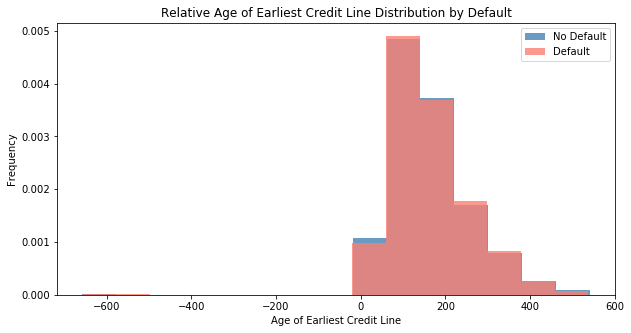

In [96]:
ax = data_test['age_of_earliest_cr_line'].loc[data['default'] == 0].plot.hist(bins=15, density = True, alpha=0.8, label='No Default', figsize = (10,5),color='steelblue')
ax = data_test['age_of_earliest_cr_line'].loc[data['default'] == 1].plot.hist(bins=15, density = True, alpha=0.8, label='Default', figsize = (10,5),color='salmon')
ax.set_xlabel('Age of Earliest Credit Line')
ax.set_title('Relative Age of Earliest Credit Line Distribution by Default')
ax.legend();

In [97]:
data_test = data_test.drop(['zip_code'], axis=1)

In [98]:
data_test['emp_title'] = data_test['emp_title'].fillna('NO_VALUE')
def emp_title_category(row):
    if row['emp_title'] == "NO_VALUE" and row['emp_length'] > 0:
        return "Employed"
    elif row['emp_title'] == "NO_VALUE" and row['emp_length'] == 0:
        return "Unemployed"
    else:
        return "Employed"
data_test = data_test.assign(emp_title_new=data_test.apply(emp_title_category, axis=1))

## Default and Employment Status

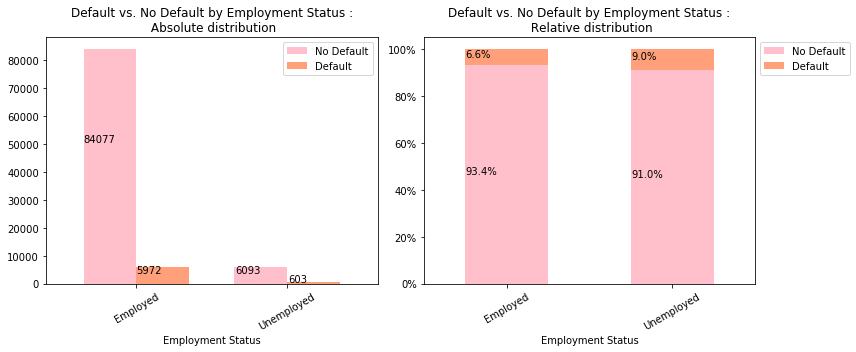

In [99]:
fig = plt.figure(figsize=(12, 5)) #specify figure size

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = data_test.groupby(['emp_title_new', 'default'])['default'].count().unstack().plot.bar(rot=30, ax=plt.gca(), width=0.7, color=['pink','lightsalmon'])
plt.title('Default vs. No Default by Employment Status :\n Absolute distribution') 
L = plt.legend()
L.get_texts()[0].set_text('No Default')
L.get_texts()[1].set_text('Default')
ax1.set_xlabel('Employment Status')
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 0.605))

#Relative distribution
plt.subplot(1, 2, 2)
ax2 = data_test.groupby(['emp_title_new','default'])['default'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=30, ax=plt.gca(), color=['pink','lightsalmon'])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Default vs. No Default by Employment Status :\n Relative distribution') 
L = plt.legend(bbox_to_anchor=(1, 1))
L.get_texts()[0].set_text('No Default')
L.get_texts()[1].set_text('Default')
ax2.set_xlabel('Employment Status')
#plot bar labels
for p, q in zip(ax2.patches[0:2], ax2.patches[2:4]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x(), p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x(), q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

In [100]:
data_test=pd.get_dummies(data_test, columns=['emp_title_new'])
data_test=data_test.drop(['emp_title'], axis=1)
data_test.head(50).style

,loan_amnt,installment,emp_length,home_ownership,annual_inc,verification_status,title,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,default,term_new,age_of_earliest_cr_line,emp_title_new_Employed,emp_title_new_Unemployed
0,15000,451.73,16,MORTGAGE,182000,Not Verified,Debt consolidation,TX,9.35,0,0,nan,nan,13,0,0,36,471,1,0
1,17000,528.73,20,MORTGAGE,120000,Not Verified,Debt consolidation,UT,8.41,0,0,72,89,9,1,0,36,100,1,0
2,20000,602.3,3,RENT,120000,Not Verified,Credit card refinancing,CA,26.54,0,1,nan,nan,18,0,0,36,138,1,0
3,16000,361.93,19,MORTGAGE,130000,Not Verified,Debt consolidation,SD,8.28,0,0,42,79,16,1,0,60,223,1,0
4,2000,71.3,6,MORTGAGE,62000,Not Verified,Credit card refinancing,WA,16.43,0,2,57,44,10,2,0,36,76,1,0
5,11875,391.26,19,MORTGAGE,55000,Not Verified,Home improvement,MI,34.5,0,0,75,nan,14,0,0,36,202,1,0
6,5000,173.31,17,RENT,68000,Not Verified,Debt consolidation,CA,22.5,0,0,27,nan,6,0,0,36,130,1,0
7,14400,483.4,0,MORTGAGE,61000,Verified,Credit card refinancing,AZ,14.24,0,0,41,nan,10,0,0,36,290,0,1
8,6800,230.73,0.5,RENT,55000,Not Verified,Credit card refinancing,CA,20.73,0,1,nan,nan,9,0,0,36,86,1,0
9,13000,401.35,20,MORTGAGE,120000,Source Verified,Debt consolidation,IL,8.3,0,0,42,nan,11,0,0,36,194,1,0


In [101]:
data_test['mths_since_last_delinq'] = data_test['mths_since_last_delinq'].fillna('10000')
data_test['mths_since_last_record'] = data_test['mths_since_last_record'].fillna('10000')
data_test['mths_since_last_delinq']=data_test['mths_since_last_delinq'].astype(int)
data_test['mths_since_last_record']=data_test['mths_since_last_record'].astype(int)
data_test.tail(10).style
data_test['home_ownership'].value_counts()
data_test['home_ownership'] = data_test['home_ownership'].replace('NONE', 'ANY')

In [102]:
data_test = pd.get_dummies(data_test, columns=['home_ownership', 'verification_status', 'title'])
data_test.head().style

,loan_amnt,installment,emp_length,annual_inc,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,default,term_new,age_of_earliest_cr_line,emp_title_new_Employed,emp_title_new_Unemployed,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,title_Business,title_Car financing,title_Credit card refinancing,title_Debt consolidation,title_Green loan,title_Home buying,title_Home improvement,title_Major purchase,title_Medical expenses,title_Moving and relocation,title_Other,title_Vacation
0,15000,451.73,16,182000,TX,9.35,0,0,10000,10000,13,0,0,36,471,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,17000,528.73,20,120000,UT,8.41,0,0,72,89,9,1,0,36,100,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,20000,602.3,3,120000,CA,26.54,0,1,10000,10000,18,0,0,36,138,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,16000,361.93,19,130000,SD,8.28,0,0,42,79,16,1,0,60,223,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,2000,71.3,6,62000,WA,16.43,0,2,57,44,10,2,0,36,76,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [103]:
#NORTHEAST
def northeast(row):
    if row['addr_state'] == 'ME' :
        return 'north_east'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(northeast, axis=1))

def northeast(row):
    if row['addr_state'] == 'NH' :
        return 'north_east'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(northeast, axis=1))


def northeast(row):
    if row['addr_state'] == 'VT' :
        return 'north_east'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(northeast, axis=1))

def northeast(row):
    if row['addr_state'] == 'MA' :
        return 'north_east'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(northeast, axis=1))

def northeast(row):
    if row['addr_state'] == 'RI' :
        return 'north_east'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(northeast, axis=1))

def northeast(row):
    if row['addr_state'] == 'CT' :
        return 'north_east'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(northeast, axis=1))

def northeast(row):
    if row['addr_state'] == 'NJ' :
        return 'north_east'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(northeast, axis=1))

def northeast(row):
    if row['addr_state'] == 'NY' :
        return 'north_east'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(northeast, axis=1))

def northeast(row):
    if row['addr_state'] == 'PA' :
        return 'north_east'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(northeast, axis=1))


In [104]:
#MIDWEST

def midwest(row):
    if row['addr_state'] == 'ND' :
        return 'mid_west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'SD' :
        return 'mid_west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'NE' :
        return 'mid_west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'KS' :
        return 'mid_west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'MN' :
        return 'mid_west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'IA' :
        return 'mid_west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'MO' :
        return 'mid_west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'WI' :
        return 'mid_west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'IL' :
        return 'mid_west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'MI' :
        return 'mid_west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'IN' :
        return 'mid_west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'OH' :
        return 'mid_west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(midwest, axis=1))


In [105]:
#SOUTH
def South(row):
    if row['addr_state'] == 'OK' :
        return 'south'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'TX' :
        return 'south'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'AR' :
        return 'south'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'LA' :
        return 'south'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'KY' :
        return 'south'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'TN' :
        return 'south'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'MS' :
        return 'south'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'AL' :
        return 'south'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'FL' :
        return 'south'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'GA' :
        return 'south'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'SC' :
        return 'south'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'NC' :
        return 'south'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'VA' :
        return 'south'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'WV' :
        return 'south'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'MD' :
        return 'south'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'DC' :
        return 'south'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'DE' :
        return 'south'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(South, axis=1))


In [106]:
def West(row):
    if row['addr_state'] == 'WA' :
        return 'west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'ID' :
        return 'west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'MT' :
        return 'west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'OR' :
        return 'west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'WY' :
        return 'west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'CA' :
        return 'west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'NV' :
        return 'west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'UT' :
        return 'west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'CO' :
        return 'west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'AZ' :
        return 'west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'NM' :
        return 'west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'AK' :
        return 'west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'HI' :
        return 'west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(West, axis=1))

In [107]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96745 entries, 0 to 96744
Data columns (total 36 columns):
loan_amnt                              96745 non-null int64
installment                            96745 non-null float64
emp_length                             96745 non-null float64
annual_inc                             96745 non-null float64
addr_state                             96745 non-null object
dti                                    96745 non-null float64
delinq_2yrs                            96745 non-null int64
inq_last_6mths                         96745 non-null int64
mths_since_last_delinq                 96745 non-null int64
mths_since_last_record                 96745 non-null int64
open_acc                               96745 non-null int64
pub_rec                                96745 non-null int64
default                                96745 non-null int64
term_new                               96745 non-null int64
age_of_earliest_cr_line                967

## Default and Region

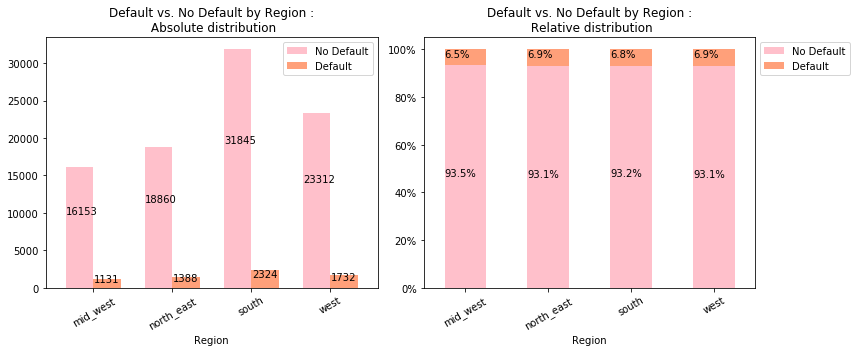

In [108]:
fig = plt.figure(figsize=(12, 5)) #specify figure size

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = data_test.groupby(['addr_state', 'default'])['default'].count().unstack().plot.bar(rot=30, ax=plt.gca(), width=0.7, color=['pink','lightsalmon'])
plt.title('Default vs. No Default by Region :\n Absolute distribution') 
L = plt.legend()
L.get_texts()[0].set_text('No Default')
L.get_texts()[1].set_text('Default')
ax1.set_xlabel('Region')
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 0.605))

#Relative distribution
plt.subplot(1, 2, 2)
ax2 = data_test.groupby(['addr_state','default'])['default'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=30, ax=plt.gca(), color=['pink','lightsalmon'])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Default vs. No Default by Region :\n Relative distribution') 
L = plt.legend(bbox_to_anchor=(1, 1))
L.get_texts()[0].set_text('No Default')
L.get_texts()[1].set_text('Default')
ax2.set_xlabel('Region')
#plot bar labels
for p, q in zip(ax2.patches[0:4], ax2.patches[4:8]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x(), p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x(), q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

In [109]:
print('Credit card refinancing proportion in default: ' + str(round(2324/6575, 5)))

Credit card refinancing proportion in default: 0.35346


In [110]:
data_test=pd.get_dummies(data_test, columns=['addr_state'])

In [111]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96745 entries, 0 to 96744
Data columns (total 39 columns):
loan_amnt                              96745 non-null int64
installment                            96745 non-null float64
emp_length                             96745 non-null float64
annual_inc                             96745 non-null float64
dti                                    96745 non-null float64
delinq_2yrs                            96745 non-null int64
inq_last_6mths                         96745 non-null int64
mths_since_last_delinq                 96745 non-null int64
mths_since_last_record                 96745 non-null int64
open_acc                               96745 non-null int64
pub_rec                                96745 non-null int64
default                                96745 non-null int64
term_new                               96745 non-null int64
age_of_earliest_cr_line                96745 non-null int64
emp_title_new_Employed                 9674

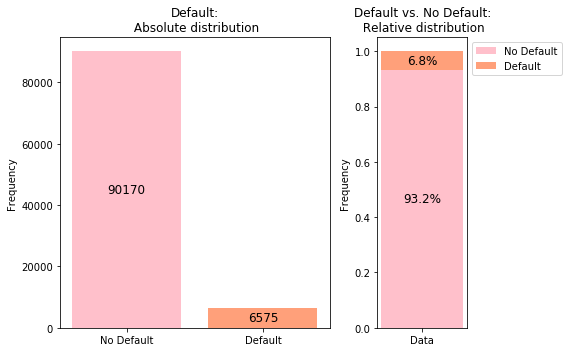

In [112]:
keys, counts = np.unique(data_test.default, return_counts=True)
counts_norm = counts/counts.sum()

fig = plt.figure(figsize=(8, 5)) #specify figure size
gs = gridspec.GridSpec(1, 2, width_ratios=[3,1]) #specify relative size of left and right plot

#Absolute values
ax0 = plt.subplot(gs[0])
ax0 = plt.bar(['No Default', 'Default'], 
              counts, color=['pink','lightsalmon']) #left bar plot
ax0 = plt.title('Default:\n Absolute distribution') 
ax0 = plt.ylabel('Frequency')
ax0 = plt.text(['No Default'], counts[0]/2, counts[0],  fontsize=12, horizontalalignment='center', verticalalignment='center') 
ax0 = plt.text(['Default'], counts[1]/2, counts[1],  fontsize=12, horizontalalignment='center', verticalalignment='center')

#Normalized values
ax1 = plt.subplot(gs[1])
ax1 = plt.bar(['Data'], [counts_norm[0]], label='No Default', color=['pink'])
ax1 = plt.bar(['Data'], [counts_norm[1]], bottom=counts_norm[0], label='Default', color=['lightsalmon'])
ax1 = plt.legend(bbox_to_anchor=(1, 1))
ax1 = plt.title('Default vs. No Default:\n Relative distribution')
ax1 = plt.ylabel('Frequency')
ax1 = plt.text(['Data'],counts_norm[0]/2, '{}%'.format((counts_norm[0]*100).round(1)), fontsize=12, horizontalalignment='center', verticalalignment='center')
ax1 = plt.text(['Data'],(counts_norm[1]/2)+counts_norm[0], '{}%'.format((counts_norm[1]*100).round(1)), fontsize=12, horizontalalignment='center', verticalalignment='center')

plt.tight_layout()
plt.show()